### CONSTRUINDO UM MODELO DE REGRESSÃO PARA MARKETING

##### INVESTIMENTO:
##### GASTO MESAL EM PLATAFORMAS DE PUBLICIDADE ONLINE PARA PROSPECÇÃO DE LEADS (PESSOAS INTERESSADAS EM SEUS PRODUTOS):
- YOUTUBE;
- FACEBOOK;
- NEWSPAPER;

##### REGISTROS:
 - GASTOS COM PUBLICIDADE
 - RETORNOS DE VENDAS GERADOS A PARTIR DESSES INVESTIMENTOS;

##### OBJETIVO:
 - ENTENDER A RELAÇÃO ENTRE AS VARIÁVEIS;
 - IDENTIFICAR OS FATORES QUE MAIS IMPACTAM NA GERAÇÃO DE LEADS;
 - CRIAR UM MODELO DE PREDIÇÃO DE VALORES PARA ESTIMAR O RETORNO DE VENDAS QUE PODE SER GERADO A PARTIR DE UM DETERMINADO INVESTIMENTO EM PUBLICIDADE;

 ##### METODOLOGIA:
 - ANÁLISE EXPLORATÓRIA COM GRÁFICOS E ESTATÍSTICAS DESCRITIVAS.


### IMPORTAÇÃO DE BIBLIOTECAS E DADOS

In [5]:
import pandas as pd
import numpy as np
import seaborn as srn
import statistics as sts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from scipy.stats import spearmanr, stats
import seaborn as sns
from IPython.display import display, HTML
import stemgraphic
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, RidgeCV
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import cm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import MinMaxScaler
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import shapiro
from scipy.stats import kstest
import warnings
from statsmodels.stats.diagnostic import het_goldfeldquandt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import kruskal


In [6]:
df = pd.read_csv("MKT.csv")

### LIMPEZA E TRATAMENTO DE DADOS

In [7]:
df.describe()

,youtube,facebook,newspaper,sales
count,171.000000,171.000000,171.000000,171.000000
mean,178.021053,27.671579,35.240000,16.922807
std,102.449597,17.913532,24.902918,6.314608
min,0.840000,0.000000,0.360000,1.920000
25%,91.080000,11.700000,13.740000,12.540000
50%,179.760000,26.760000,31.080000,15.480000
75%,262.980000,43.680000,50.880000,20.820000
max,355.680000,59.520000,121.080000,32.400000


In [8]:
# Verificar valores nulos
df.isnull().sum()

youtube      0
facebook     0
newspaper    0
sales        0
dtype: int64

In [9]:
# Remover linhas com valores nulos
df = df.dropna()

In [10]:
# Verificar o tipo de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   youtube    171 non-null    float64
 1   facebook   171 non-null    float64
 2   newspaper  171 non-null    float64
 3   sales      171 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


No resumo descritivo dos dados pode ser observado que os valores da coluna explicativa youtube, tem a possibilidade de existir um erro de escala. Os valores foram adequados apenas para dar fluidez nas análises, mas não apresenta alterações nas análises posteriores se a escala for mantida.

In [11]:
# Adequando aescala dos valores da coluna youtube
df['youtube'] = df['youtube']/10

In [12]:
# Resumo descritivo dos dados
df.describe()

,youtube,facebook,newspaper,sales
count,171.000000,171.000000,171.000000,171.000000
mean,17.802105,27.671579,35.240000,16.922807
std,10.244960,17.913532,24.902918,6.314608
min,0.084000,0.000000,0.360000,1.920000
25%,9.108000,11.700000,13.740000,12.540000
50%,17.976000,26.760000,31.080000,15.480000
75%,26.298000,43.680000,50.880000,20.820000
max,35.568000,59.520000,121.080000,32.400000


### FUNÇÕES

In [13]:
def teste_shapiro(coluna):
    stats.shapiro(coluna)
    estatistica, p = stats.shapiro(coluna)
    return f' Teste de Shapiro-Wilk: \n| Estatística: {round(estatistica, 2)} \n| Valor de p: {p} '

In [14]:
def teste_smirnov(coluna):
    stats.kstest(coluna,'norm')
    estatistica, p = stats.kstest(coluna,'norm')
    return f'Teste de Kolmogorov-Smirnov: \n| Estatística: {round(estatistica, 2)} \n| Valor de p: {p} '


In [15]:
def posicao(coluna):
    media = round(coluna.mean(),3)
    mediana = round(coluna.median(),3)
    Q1 = round(coluna.quantile(0.25),3)
    Q2 = round(coluna.quantile(0.50),3)
    Q3 = round(coluna.quantile(0.75),3)
    valores_unicos, contagem = np.unique(coluna, return_counts=True)
    moda = round(valores_unicos[np.argmax(contagem)])
    return f'Medidas de Tendência Central:\n| Média: {media:>6} \n| Mediana: {mediana:>4} \n| Moda: {moda:>7} \n\nSeparatrizes: \n| 1º Quartil : {Q1:>3} \n| 2º Quartil: {Q2:>4} \n| 3º Quartil: {Q3:>4}'

In [16]:
def dispersao(coluna):
    maximo=round(coluna.max())
    minimo=round(coluna.min(),2)
    desvio_padrao = round(coluna.std())
    variancia = round(coluna.var(),2)
    amplitude = round(coluna.max() - coluna.min())
    IQR = round(coluna.quantile(0.75) - coluna.quantile(0.25))
    return f'Medidas de Dispersão:\n| Mínimo: {minimo:>21}\n| Máximo: {maximo:>21}\n| Desvio Padrão: {desvio_padrao:>14} \n| Variância: {variancia:>18} \n| Amplitude: {amplitude:>18} \n| Intervalo interquartil: {IQR:>5}'

In [17]:
def histograma(coluna, classe_largura, barra_largura):
    amplitude = round(coluna.max() - coluna.min())
    plt.figure(figsize=(16, 6))
    plt.hist(coluna, bins=np.arange(0, amplitude*1.05, barra_largura), edgecolor='black', orientation='vertical', color='skyblue')
    plt.xlabel('População (em milhares)')
    plt.ylabel('Frequência')
    plt.title('Diagrama de Ramos e Folhas (Adaptado)')
    plt.grid(True, linestyle='--', alpha=0.8)
    plt.xticks(np.arange(0, amplitude*1.05, classe_largura))
    return plt.show()

In [18]:
def QQ(coluna):
    fig, ax = plt.subplots()
    stats.probplot(coluna, fit=True,   plot=ax)
    return plt.show(fig)

In [19]:
def boxplot(coluna):
    fig = px.box(coluna, x = coluna, width=1000, height= 400)
    return fig.update_traces(line_color="skyblue")

In [20]:
df_tabela = df.copy()
def tab_contingencia(df, x_coluna, y_coluna):
    # Dividindo as colunas X e Y em bins diretamente
    df_tabela['X_bins'] = pd.cut(df_tabela[x_coluna], bins=4)
    df_tabela['Y_bins'] = pd.cut(df_tabela[y_coluna], bins=4)
    # Gerando a tabela de contingência
    contingency_table = pd.crosstab(df_tabela['X_bins'], df_tabela['Y_bins'])
    # Exibindo a tabela de contingência simples
    return contingency_table

In [21]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import pandas as pd

# Função para calcular estatísticas resumidas e formatá-las em HTML
def estatisticas_resumidas(coluna):
    # Verifica se os dados são numéricos
    if not pd.api.types.is_numeric_dtype(coluna):
        raise ValueError("A coluna deve conter valores numéricos.")

    shapiro_stat, shapiro_p = stats.shapiro(coluna)
    ks_stat, ks_p = stats.kstest(coluna, 'norm')

    # Medidas de Tendência Central
    media = round(coluna.mean(), 3)
    mediana = round(coluna.median(), 3)
    moda = round(coluna.mode().values[0], 3)
    Q1 = round(coluna.quantile(0.25), 3)
    Q2 = round(coluna.quantile(0.5), 3)
    Q3 = round(coluna.quantile(0.75), 3)

    # Dispersão
    maximo = round(coluna.max(), 2)
    minimo = round(coluna.min(), 2)
    desvio_padrao = round(coluna.std(), 2)
    variancia = round(coluna.var(), 2)
    amplitude = maximo - minimo
    IQR = round(Q3 - Q1, 2)

    # Gerando HTML
    stats_html = f"""
    <div style="display: inline-block; vertical-align: top; width: 45%; padding-right: 20px;">
        <h3>Estatísticas Resumidas</h3>
        <strong>Teste Shapiro–Wilk:</strong><br>Estatística: {shapiro_stat:.2f}, p-valor: {shapiro_p:.2e}<br><br>
        <strong>Teste Kolmogorov–Smirnov:</strong><br>Estatística: {ks_stat:.2f}, p-valor: {ks_p:.2e}<br><br>
        <strong>Medidas de Tendência Central:</strong><br>
        Média: {media}<br>Mediana: {mediana}<br>Moda: {moda}<br>
        Q1: {Q1}<br>Q2 (Mediana): {Q2}<br>Q3: {Q3}<br><br>
        <strong>Medidas de Dispersão:</strong><br>
        Mínimo: {minimo}<br>Máximo: {maximo}<br>
        Desvio Padrão: {desvio_padrao}<br>Variância: {variancia}<br>
        Amplitude: {amplitude:.2f}<br>DQ (IQR): {IQR}
    </div>
    """
    return stats_html

# Função para plotar histograma, Q-Q plot e boxplot lado a lado
def graficos(coluna, largura_dos_bins=5):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Histograma
    axs[0].hist(coluna, bins=np.arange(coluna.min(), coluna.max() + largura_dos_bins, largura_dos_bins), color="skyblue", edgecolor="black")
    axs[0].set_title("Histograma")
    axs[0].set_xlabel("Valor")
    axs[0].set_ylabel("Frequência")

    # Q-Q Plot
    stats.probplot(coluna, dist="norm", plot=axs[1])
    axs[1].set_title("Q-Q Plot")

    # Boxplot
    axs[2].boxplot(coluna, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))
    axs[2].set_title("Boxplot")
    axs[2].set_xlabel("Valor")

    plt.tight_layout()
    return fig

# Exibir estatísticas resumidas e gráficos lado a lado
def exibir_estatisticas_e_graficos(coluna):
    stats_html = estatisticas_resumidas(coluna)
    graficos(coluna)  # Não é necessário salvar o retorno em fig

    # Exibir as estatísticas
    display(HTML(stats_html))
    # Exibe o gráfico
    plt.show()


In [22]:
def grafico_dispersao(var_explicativa, var_resposta, largura, altura):

    x = var_explicativa
    y = var_resposta

    # Regressão linear:
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # Configuração da visualização:
    fig, ax = plt.subplots(figsize=(largura, altura))
    line_eq = f'ŷ = {intercept:.2f} + {slope:.2f}x'
    residuals = y - (slope * x + intercept)
    # Plotando dados, linha de regressão e resíduos:
    ax.plot(x, y, 'o', color='#1f77b4', label='Dados')
    ax.plot(x, slope * x + intercept, color='#d62728', label=line_eq)
    # Identificando as observações:
    xy_list = list(zip(x, y))
    for i, txt in enumerate(df.index):
        plt.annotate(txt, xy_list[i], fontsize=10, color='black')
    # Linhas de resíduos:
    for i in residuals.index:
        ax.plot([x[i], x[i]], [y[i], y[i] - residuals[i]], 'k-', linewidth=0.8)
    # Anotações e ajustes de visualização:
    ax.axvline(x.mean(), color='blue', linestyle='--')
    ax.axhline(y.mean(), color='green', linestyle='--')
    ax.set_xlabel('Variável Explicativa')
    ax.set_ylabel('Variável Resposta')
    ax.legend()
    print(f" \n | Coeficiente angular: {round(slope, 3)} | Intercepto: {round(intercept, 3)} | Coeficiente de correlação: {round(r_value, 3)} | Valor-p (hipótese de inclinação): {round(p_value, 5)} | Erro padrão de inclinação: {round(std_err, 5)} ")
    return plt.show()

In [23]:
def observacoes_coordenadas(coluna_x, coluna_y, intervalo_inicio, intervalo_fim):
    # Criando uma cópia do DataFrame:
    df_coordenada = df.copy()
    coordenadas = pd.DataFrame(list(zip(df_coordenada[coluna_x], df_coordenada[coluna_y])), columns=['x', 'y'])


    return coordenadas[intervalo_inicio:intervalo_fim]


In [24]:
def selecao_observacao(base_dados, observacoes):
    # Se 'observations' for um único valor, transforma-o em uma lista
    if isinstance(observacoes, int):
        observacoes = [observacoes]
    # Seleciona as linhas e arredonda para duas casas decimais
    selecao = base_dados.loc[observacoes].round(2)
    return selecao

### ANÁLISE EXPLORATÓRIA DE DADOS (AED) - ANÁLISE UNIVARIADA


#### VARIÁVEL EXPLICATIVA -  YOUTUBE


Observações:
- As variáveis são quantitativas;
- Os dados 'youtube' não seguem uma distribuição normal hipótese alternativa (H1);
- Os valores de medida central, média e mediana, têm seus valores aproximados, essa informação associada aos gráficos, indicam que os dados possuem uma distribuição uniforme, que é simétrica, não normal e com caudas leves;
- Com base no coeficiente de variação (CV > 30%), na comparação  do desvio padrão com a média e na amplitude relativa, a variância pode ser considerada alta;
- Para mais informações sobre medidas de posição, consulte Moretin e Singer (2022, p. 112).
- Para mais informações sobre medidas de dispersão, consulte Moretin e Singer (2022, p. 115).

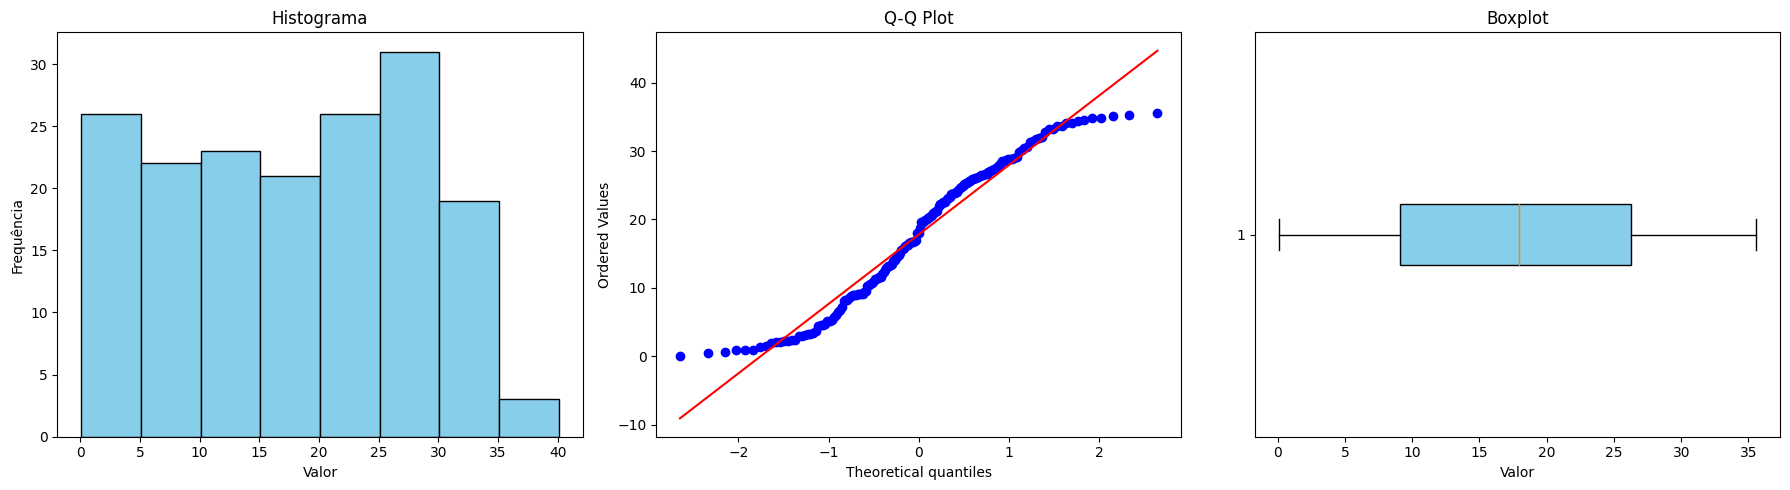

In [25]:
# Exibir medidas de resumo e vizualização gráfica
exibir_estatisticas_e_graficos(df["youtube"])

In [26]:
# # Criando o gráfico de ramos e folhas
# stemgraphic.stem_graphic(df['youtube'], scale=1, title="Ramos-e-Folhas Plot")
# plt.show()

IDENTIFICAÇÃO DE VALORES ATÍPICOS (OUTLIER)

Método de desvios padrões

In [27]:
dados_dp = df['youtube']
# Calculando a média dos dados para cáculos dos limites
media = np.mean(dados_dp)
# calculando o desvio padrão dos dados para cálculo dos limites
desvio_padrao = np.std(dados_dp)
# Identificando valores atípicos (valores que estão fora de 3 desvios padrão)
limite_inferior = media - 3 * desvio_padrao
limite_superior = media + 3 * desvio_padrao
valores_atipicos = dados_dp[(dados_dp <= limite_inferior) | (dados_dp >= limite_superior)]
print(f'Valores atípicos encontrados: \n{valores_atipicos}')

Valores atípicos encontrados: 
Series([], Name: youtube, dtype: float64)


Método dos quantis (IQR)
- Visto que os dados não seguem uma distribuição normal foi aplicado o método dos quantis(IQR), que por sua vez é mais efetivo em dados assimétricos

In [28]:
dados_IQR = df['youtube']
# Calculando Q1, Q3 e IQR
Q1 = dados_IQR.quantile(0.25)
Q3 = dados_IQR.quantile(0.75)
DQ = Q3 - Q1
# Definindo os limites para os valores
limite_inferior = Q1 - 1.5 * DQ
limite_superior = Q3 + 1.5 * DQ
# Encontrando os outliers
valores_atipicos = dados_IQR[(dados_IQR < limite_inferior) | (dados_IQR > limite_superior)]
# Imprimindo os valores atípicos encontrados
print("Valores atípicos encontrados:")
print(valores_atipicos)

Valores atípicos encontrados:
Series([], Name: youtube, dtype: float64)


Remoção dos valores atípicos, adotando o método dos quantis.

In [29]:
# Removendo valores atípicos (outliers)
Q1 = df['youtube'].quantile(0.25)
Q3 = df['youtube'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrando para remover outliers
df = df[(df['youtube'] >= limite_inferior) & (df['youtube'] <= limite_superior)]

#### VARIÁVEL EXPLICATIVA -  FACEBOOK

Observações:
- As variáveis são quantitativas;
- Os dados 'facebook' não seguem uma distribuição normal hipótese alternativa (H1);
- Os valores de medida central, média e mediana, têm seus valores aproximados, essa informação associada aos gráficos, indicam que os dados possuem uma distribuição Beta - pode-se considerar, também, como distribuição uniforme, para simplicidade do modelo - , que é aproximadamente simétrica, não normal e caudas leves com um leve alongamento à esquerda (assimetria à esquerda);
- Com base no coeficiente de variação, (CV > 30%), na comparação  do desvio padrão com a média e na amplitude relativa, a variância pode ser considerada alta;
- Para mais informações sobre medidas de posição, consulte Moretin e Singer (2022, p. 112).
- Para mais informações sobre variáveis aleatórias contínuas (distribuição Beta), consulte Campos, Rêgo e Mendonça (2012, p. 106).
- Para mais informações sobre medidas de dispersão, consulte Moretin e Singer (2022, p. 115).

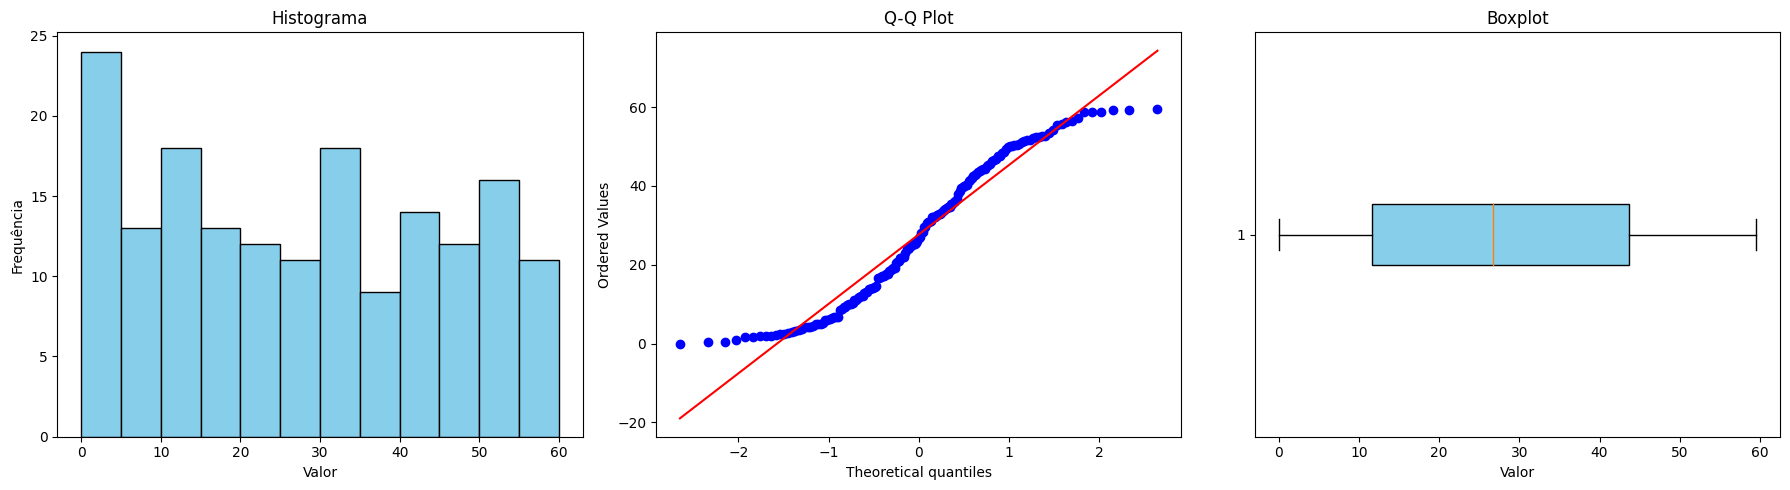

In [30]:
# Exibir medidas de resumo e vizualização gráfica
exibir_estatisticas_e_graficos(df["facebook"])

In [31]:
# # Criando o gráfico de ramos e folhas
# data = df['facebook']
# stemgraphic.stem_graphic(data, scale=1, title="Ramos-e-Folhas Plot")
# plt.show()

IDENTIFICAÇÃO DE VALORES ATÍPICOS (OUTLIER)

Método de desvios padrões

In [32]:
dados_dp = df['facebook']
# Calculando a média dos dados para cáculos dos limites
media = np.mean(dados_dp)
# calculando o desvio padrão dos dados para cálculo dos limites
desvio_padrao = np.std(dados_dp)
# Identificando valores atípicos (valores que estão fora de 3 desvios padrão)
limite_inferior = media - 3 * desvio_padrao
limite_superior = media + 3 * desvio_padrao
valores_atipicos = dados_dp[(dados_dp <= limite_inferior) | (dados_dp >= limite_superior)]
print(f'Valores atípicos encontrados: \n{valores_atipicos}')

Valores atípicos encontrados: 
Series([], Name: facebook, dtype: float64)


Método dos quantis (IQR)
- Visto que os dados não seguem uma distribuição normal foi aplicado o método dos quantis(IQR), que por sua vez é mais efetivo em dados assimétricos

In [33]:
dados_IQR = df['facebook']
# Calculando Q1, Q3 e IQR
Q1 = dados_IQR.quantile(0.25)
Q3 = dados_IQR.quantile(0.75)
DQ = Q3 - Q1
# Definindo os limites para os valores
limite_inferior = Q1 - 1.5 * DQ
limite_superior = Q3 + 1.5 * DQ
# Encontrando os outliers
valores_atipicos = dados_IQR[(dados_IQR < limite_inferior) | (dados_IQR > limite_superior)]
# Imprimindo os valores atípicos encontrados
print("Valores atípicos encontrados:")
print(valores_atipicos)

Valores atípicos encontrados:
Series([], Name: facebook, dtype: float64)


Remoção dos valores atípicos, adotando o método dos quantis.

In [34]:
# Removendo valores atípicos (outliers)
Q1 = df['facebook'].quantile(0.25)
Q3 = df['facebook'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrando para remover outliers
df = df[(df['facebook'] >= limite_inferior) & (df['facebook'] <= limite_superior)]

#### VARIÁVEL EXPLICATIVA - NEWSPAPER

Observações:
- As variáveis são quantitativas;
- Os dados 'newspaper' não seguem uma distribuição normal hipótese alternativa (H1);
- No histograma pode ser visto que a maior parte dos valores estão concentrados à esquerda, o QQ com a cauda mais pesada à direita, o boxplot mostra a presença de um valor atípico no lado superior, indicando que os dados possuem uma distribuição gama, que é assimétrica à direita, não normal e cauda pesada à direita;
- Com base no coeficiente de variação, (CV > 30%), na comparação  do desvio padrão com a média e na amplitude relativa, a variância pode ser considerada alta;
- Para mais informações sobre medidas de posição, consulte Moretin e Singer (2022, p. 112).
- Para mais informações sobre variáveis aleatórias contínuas (distribuição gama), consulte Campos, Rêgo e Mendonça (2012, p. 202).
- Para mais informações sobre medidas de dispersão, consulte Moretin e Singer (2022, p. 115).

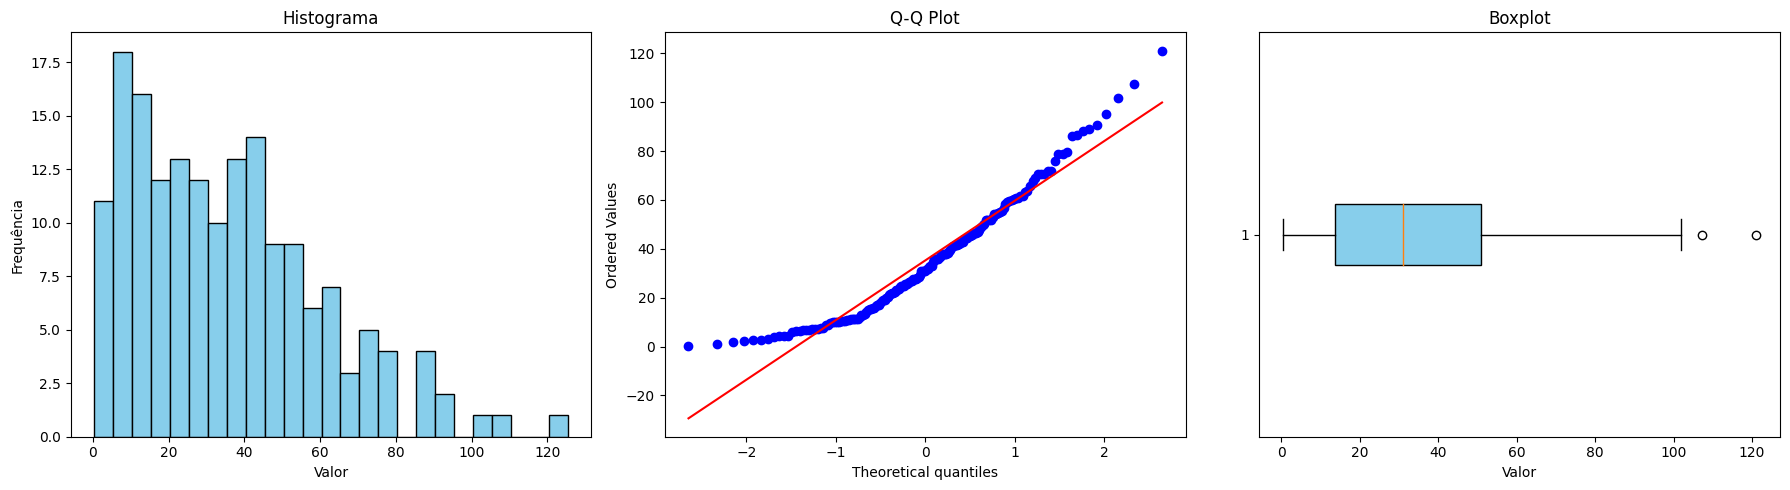

In [35]:
exibir_estatisticas_e_graficos(df["newspaper"])

In [36]:
# # Criando o gráfico de ramos e folhas
# data = df['newspaper']
# stemgraphic.stem_graphic(data, scale=1, title="Ramos-e-Folhas Plot")
# plt.show()

IDENTIFICAÇÃO DE VALORES ATÍPICOS (OUTLIER)

Método de desvios padrões

In [37]:
dados_dp = df['newspaper']
# Calculando a média dos dados para cáculos dos limites
media = np.mean(dados_dp)
# calculando o desvio padrão dos dados para cálculo dos limites
desvio_padrao = np.std(dados_dp)
# Identificando valores atípicos (valores que estão fora de 3 desvios padrão)
limite_inferior = media - 3 * desvio_padrao
limite_superior = media + 3 * desvio_padrao
valores_atipicos = dados_dp[(dados_dp <= limite_inferior) | (dados_dp >= limite_superior)]
print(f'Valores atípicos encontrados: \n{valores_atipicos}')

Valores atípicos encontrados: 
72    121.08
Name: newspaper, dtype: float64


Método dos quantis (IQR)
- Visto que os dados não seguem uma distribuição normal foi aplicado o método dos quantis(IQR), que por sua vez é mais efetivo em dados assimétricos

In [38]:
dados_IQR = df['newspaper']
# Calculando Q1, Q3 e IQR
Q1 = dados_IQR.quantile(0.25)
Q3 = dados_IQR.quantile(0.75)
DQ = Q3 - Q1
# Definindo os limites para os valores
limite_inferior = Q1 - 1.5 * DQ
limite_superior = Q3 + 1.5 * DQ
# Encontrando os outliers
valores_atipicos = dados_IQR[(dados_IQR < limite_inferior) | (dados_IQR > limite_superior)]
# Imprimindo os valores atípicos encontrados
print("Valores atípicos encontrados:")
print(valores_atipicos)

Valores atípicos encontrados:
46    107.28
72    121.08
Name: newspaper, dtype: float64


Remoção dos valores atípicos, adotando o método dos quantis.

In [39]:
# Removendo valores atípicos (outliers)
Q1 = df['newspaper'].quantile(0.25)
Q3 = df['newspaper'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrando para remover outliers
df = df[(df['newspaper'] >= limite_inferior) & (df['newspaper'] <= limite_superior)]

In [40]:
# df.describe()

#### VARIÁVEL EXPLICATIVA - SALES

Observações:
- As variáveis são quantitativas;
- Os valores de medida central, média e mediana dos dados 'sales', têm seus valores aproximados, essa informação associada ao histograma com leve assimetria à direita, o QQ com pequeno desvios nos extremos superiores, o boxplot com a mediana ligeiramente deslocada para os valores mais baixos indicam que os dados seguem uma distribuição Log-normal.
- Com base no coeficiente de variação, na comparação  do desvio padrão com a média e na amplitude relativa, a variância pode ser considerada moderada (apesar do CV>30%);
- Para mais informações sobre medidas de posição, consulte Moretin e Singer (2022, p. 112).
- Para mais informações sobre variáveis aleatórias contínuas (distribuição Log-normal), consulte Campos, Rêgo e Mendonça (2012, p. 201).
- Para mais informações sobre medidas de dispersão, consulte Moretin e Singer (2022, p. 115).

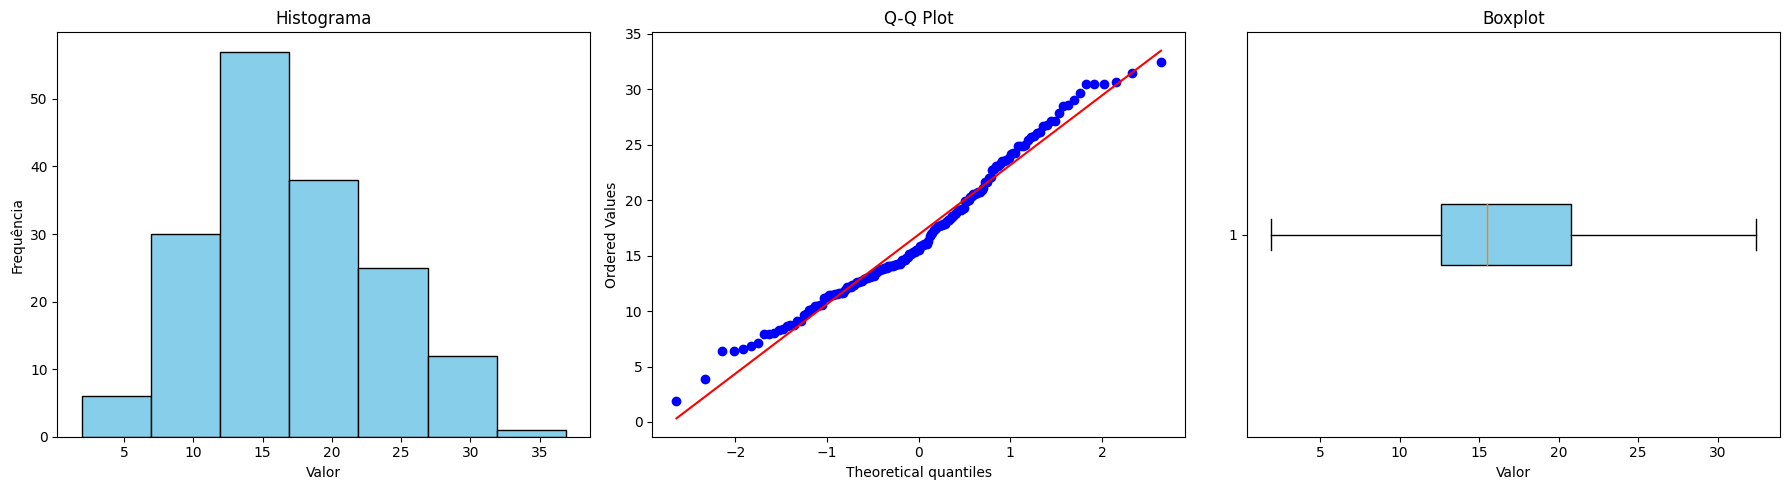

In [41]:
exibir_estatisticas_e_graficos(df["sales"])

In [42]:
# data = df['sales']
# # Criando o gráfico de ramos e folhas
# stemgraphic.stem_graphic(data, scale=1, title="Ramos-e-Folhas Plot")
# plt.show()

IDENTIFICAÇÃO DE VALORES ATÍPICOS (OUTLIER)

Método de desvios padrões

In [43]:
dados_dp = df['sales']
# Calculando a média dos dados para cáculos dos limites
media = np.mean(dados_dp)
# calculando o desvio padrão dos dados para cálculo dos limites
desvio_padrao = np.std(dados_dp)
# Identificando valores atípicos (valores que estão fora de 3 desvios padrão)
limite_inferior = media - 3 * desvio_padrao
limite_superior = media + 3 * desvio_padrao
valores_atipicos = dados_dp[(dados_dp <= limite_inferior) | (dados_dp >= limite_superior)]
print(f'Valores atípicos encontrados: \n{valores_atipicos}')

Valores atípicos encontrados: 
Series([], Name: sales, dtype: float64)


Método dos quantis (IQR)
- Visto que os dados não seguem uma distribuição normal foi aplicado o método dos quantis(IQR), que por sua vez é mais efetivo em dados assimétricos

In [44]:
dados_IQR = df['sales']
# Calculando Q1, Q3 e IQR
Q1 = dados_IQR.quantile(0.25)
Q3 = dados_IQR.quantile(0.75)
DQ = Q3 - Q1
# Definindo os limites para os valores
limite_inferior = Q1 - 1.5 * DQ
limite_superior = Q3 + 1.5 * DQ
# Encontrando os outliers
valores_atipicos = dados_IQR[(dados_IQR < limite_inferior) | (dados_IQR > limite_superior)]
# Imprimindo os valores atípicos encontrados
print("Valores atípicos encontrados:")
print(valores_atipicos)

Valores atípicos encontrados:
Series([], Name: sales, dtype: float64)


Remoção dos valores atípicos, adotando o método dos quantis.

In [45]:
# Removendo valores atípicos (outliers)
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrando para remover outliers
df = df[(df['sales'] >= limite_inferior) & (df['sales'] <= limite_superior)]

### ANÁLISE EXPLORATÓRIA DE DADOS (AED) - ANÁLISE BIVARIADA

"De maneira geral, dizemos que existe associação entre duas variáveis se o conhecimento do valor de uma delas nos dá alguma informação sobre alguma característica da distribuição (de frequências) da outra."(Morettin e Singer, 2022, p. 161).

#### YOUTUBE - SALES
- YOUTUBE - VARIÁVEL PREDITORA
- SALES - VARIÁVEL RESPOSTA

Observações:
- O gráfico apresenta características de heterocedasticidade;
- Analizando os resíduos - linhas pretas na vertical - pode ser observado uma grande variabilidade na relação dos dados youtube e sales;
- Após a média (traços azuis) os dados sofrem uma inflexão, ou seja, se desviam mais da linearidade - possível não linearidade;
- O coeficiente angular positivo indica uma relação linear crescente;
- O teste de hipotese com p < 0.05 indica a significancia estatística, indicando que existe uma relação linear entre os dados youtube e sales;
- É possível existir uma possível saturação dos dados, visto que para os valores altos de x (x > 25), os dados parecem se "nivelar" (menos variação em y - sales), caracterizando uma diminuição dos retornos marginais.
- Para mais informações sobre características de heterocedasticidade, consulte Singer, Nobre, Rocha (2018, p. 221).

Gráfico de dispersão com ajuste linear definido pela função  $
\hat{y} = \beta_0 + \beta_1 x
$


In [46]:
# # Campo para selecionar as observações para análises (número da observação e coordenadas dos vetores)
# selecao_youtube = selecao_observacao(df[['youtube', 'sales']], [6,149,102,145,93,52,71,21,101]).sort_values(by='sales')

# print(f"Observações selecionadas (ordenadas por sales) para youtube:\n{selecao_youtube}")

Obs. Coordenadas:
        x      y
1  35.148  25.68
2  13.548  14.28
 
 | Coeficiente angular: 0.48 | Intercepto: 8.355 | Coeficiente de correlação: 0.776 | Valor-p (hipótese de inclinação): 0.0 | Erro padrão de inclinação: 0.03014 


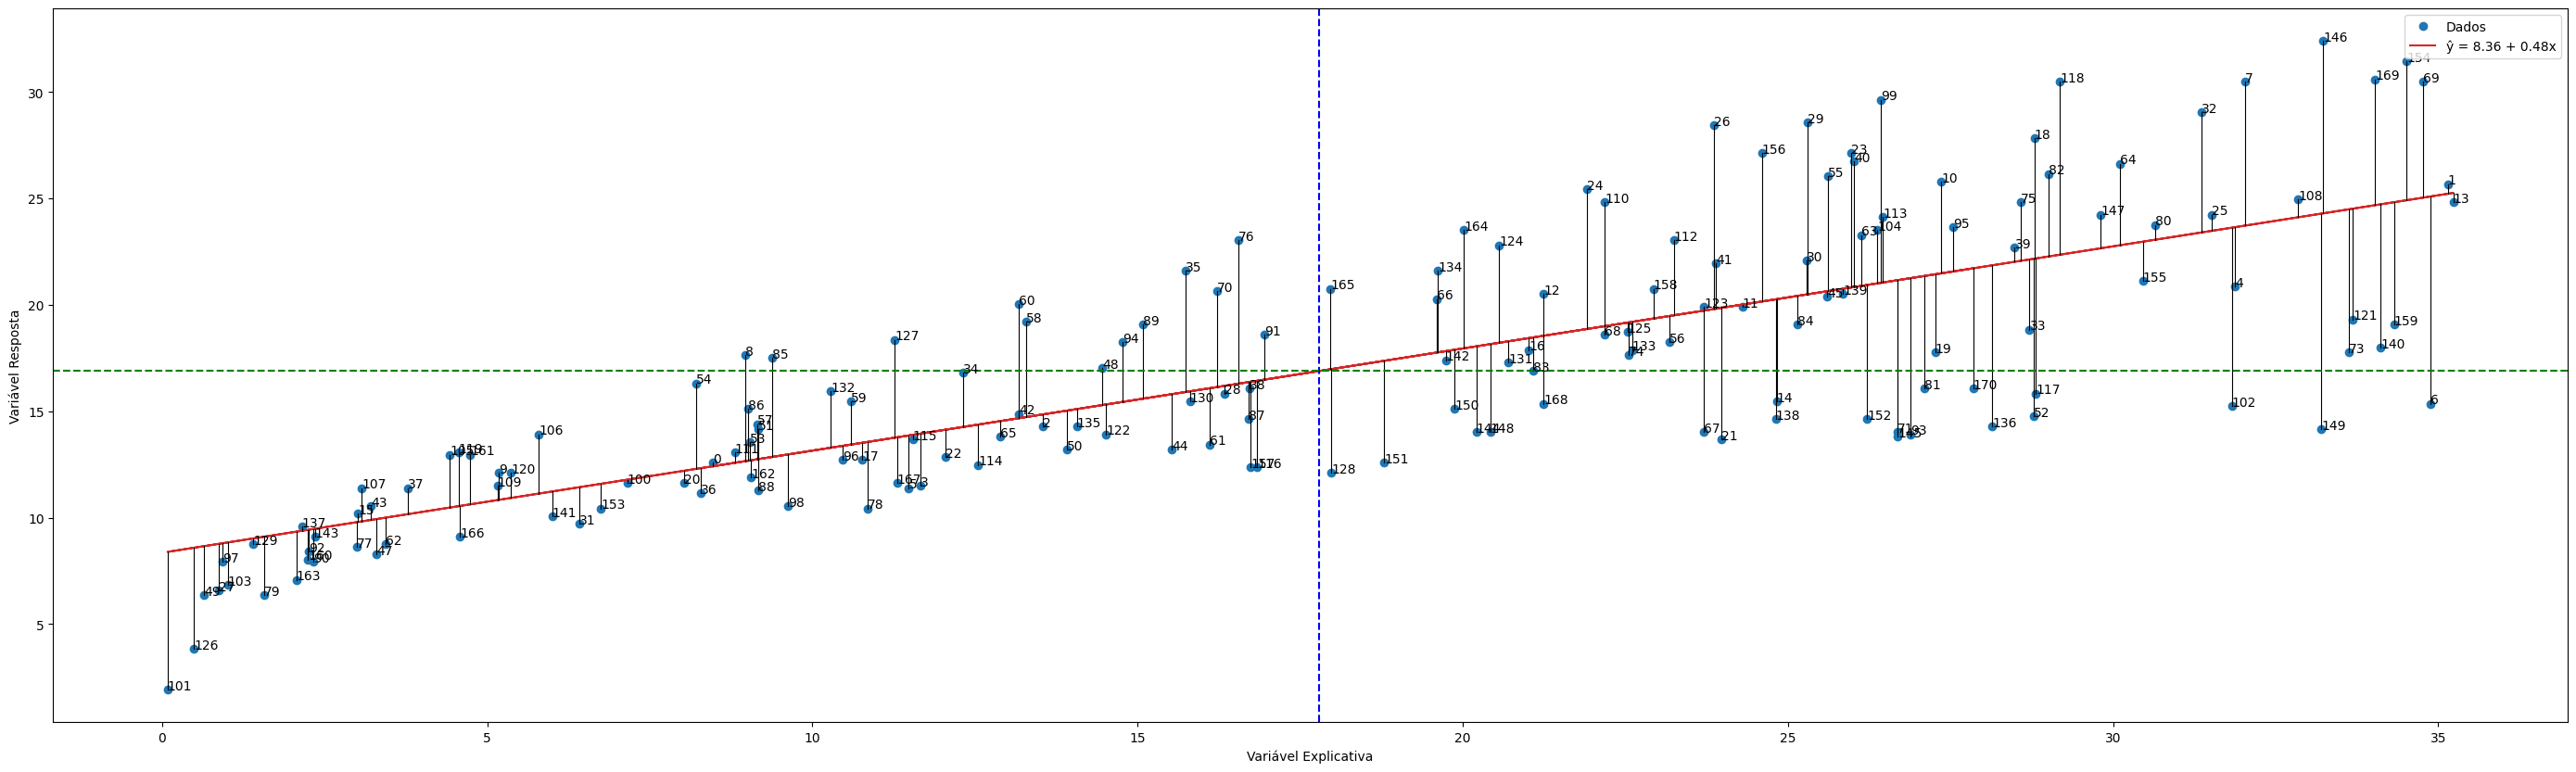

In [47]:

# Campo para selecionar trechos das observações para análises (número da observação e coordenadas dos vetores)
print(f"Obs. Coordenadas:\n{observacoes_coordenadas('youtube', 'sales', 1, 3)}")
# Plocar gráfico de dispersão com observações identificadas e valores para análise de linearidade:
grafico_dispersao(df['youtube'], df['sales'], 35, 10)

/var/folders/q4/msgggjcn0c9448__nbm848r00000gn/T/ipykernel_28944/1028195200.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




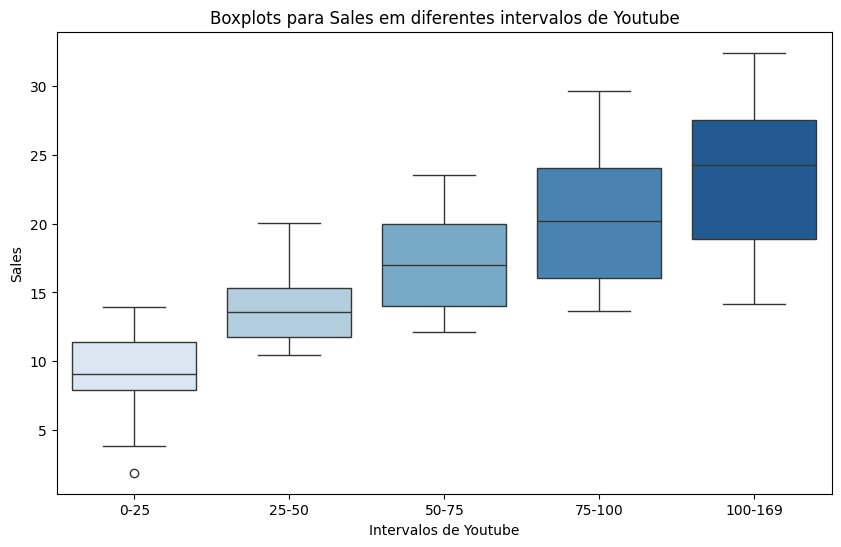

In [48]:
# Boxplot para diferentes intervalos
df_cut = df.copy()
# Criando intervalos de 'youtube' para categorizar
df_cut['youtube_bins'] = pd.cut(df_cut['youtube'], bins=5, labels=["0-25", "25-50", "50-75", "75-100", "100-169"])
# Plotando o gráfico de boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cut, x='youtube_bins', y='sales', palette="Blues")
# Adicionando títulos e rótulos
plt.title("Boxplots para Sales em diferentes intervalos de Youtube")
plt.xlabel("Intervalos de Youtube")
plt.ylabel("Sales")
plt.show()


In [49]:
# Agrupando os dados por intervalo
grupos_youtube = [df_cut.loc[df_cut['youtube'] == bin, 'sales'] for bin in df_cut['youtube'].unique()]

# Teste de ANOVA
stat, p = f_oneway(*grupos_youtube)
print(f"Estatística F (ANOVA): {stat:.4f}, p-valor: {p:.4f}")

# Interpretação
if p < 0.05:
    print("Diferenças significativas entre os grupos.")
else:
    print("Não há diferenças significativas entre os grupos.")

Estatística F (ANOVA): 3.5818, p-valor: 0.0539
Não há diferenças significativas entre os grupos.


In [50]:
# Teste de Kruskal-Wallis
stat, p = kruskal(*grupos_youtube)
print(f"Estatística Kruskal-Wallis: {stat:.4f}, p-valor: {p:.4f}")

# Interpretação
if p < 0.05:
    print("Diferenças significativas entre os grupos.")
else:
    print("Não há diferenças significativas entre os grupos.")

Estatística Kruskal-Wallis: 165.9925, p-valor: 0.3986
Não há diferenças significativas entre os grupos.


#### FACEBOOK - SALES
- FACEBOOK - VARIÁVEL PREDITORA
- SALES - VARIÁVEL RESPOSTA

Observações:
- O gráfico apresenta características de heterocedasticidade;
- Analizando os resíduos - linhas pretas na vertical - pode ser observado uma grande variabilidade na relação dos dados facebook e sales;
- Há indícios leves de não linearidade
- O coeficiente angular positivo indica uma relação linear crescente;
- O teste de hipotese com p < 0.05 indica a significancia estatística, indicando que existe uma relação linear entre os dados facebook e sales;
- É possível observar saturação dos dados para valores altos da variável explicativa (x>30), em que a variabilidade da variável resposta diminui, caracterizando retornos marginais decrescentes.
- Para mais informações sobre características de heterocedasticidade, consulte Singer, Nobre, Rocha (2018, p. 221).

In [51]:
# # Campo para selecionar as observações para análises (número da observação e coordenadas dos vetores)
# selecao_facebook = selecao_observacao(df[['facebook', 'sales']], [98]).sort_values(by='sales')

# print(f"Observações selecionadas (ordenadas por sales) para facebook:\n{selecao_facebook}")

Obs. Coordenadas:
       x      y
1  33.96  25.68
2  20.88  14.28
 
 | Coeficiente angular: 0.216 | Intercepto: 10.98 | Coeficiente de correlação: 0.615 | Valor-p (hipótese de inclinação): 0.0 | Erro padrão de inclinação: 0.02141 


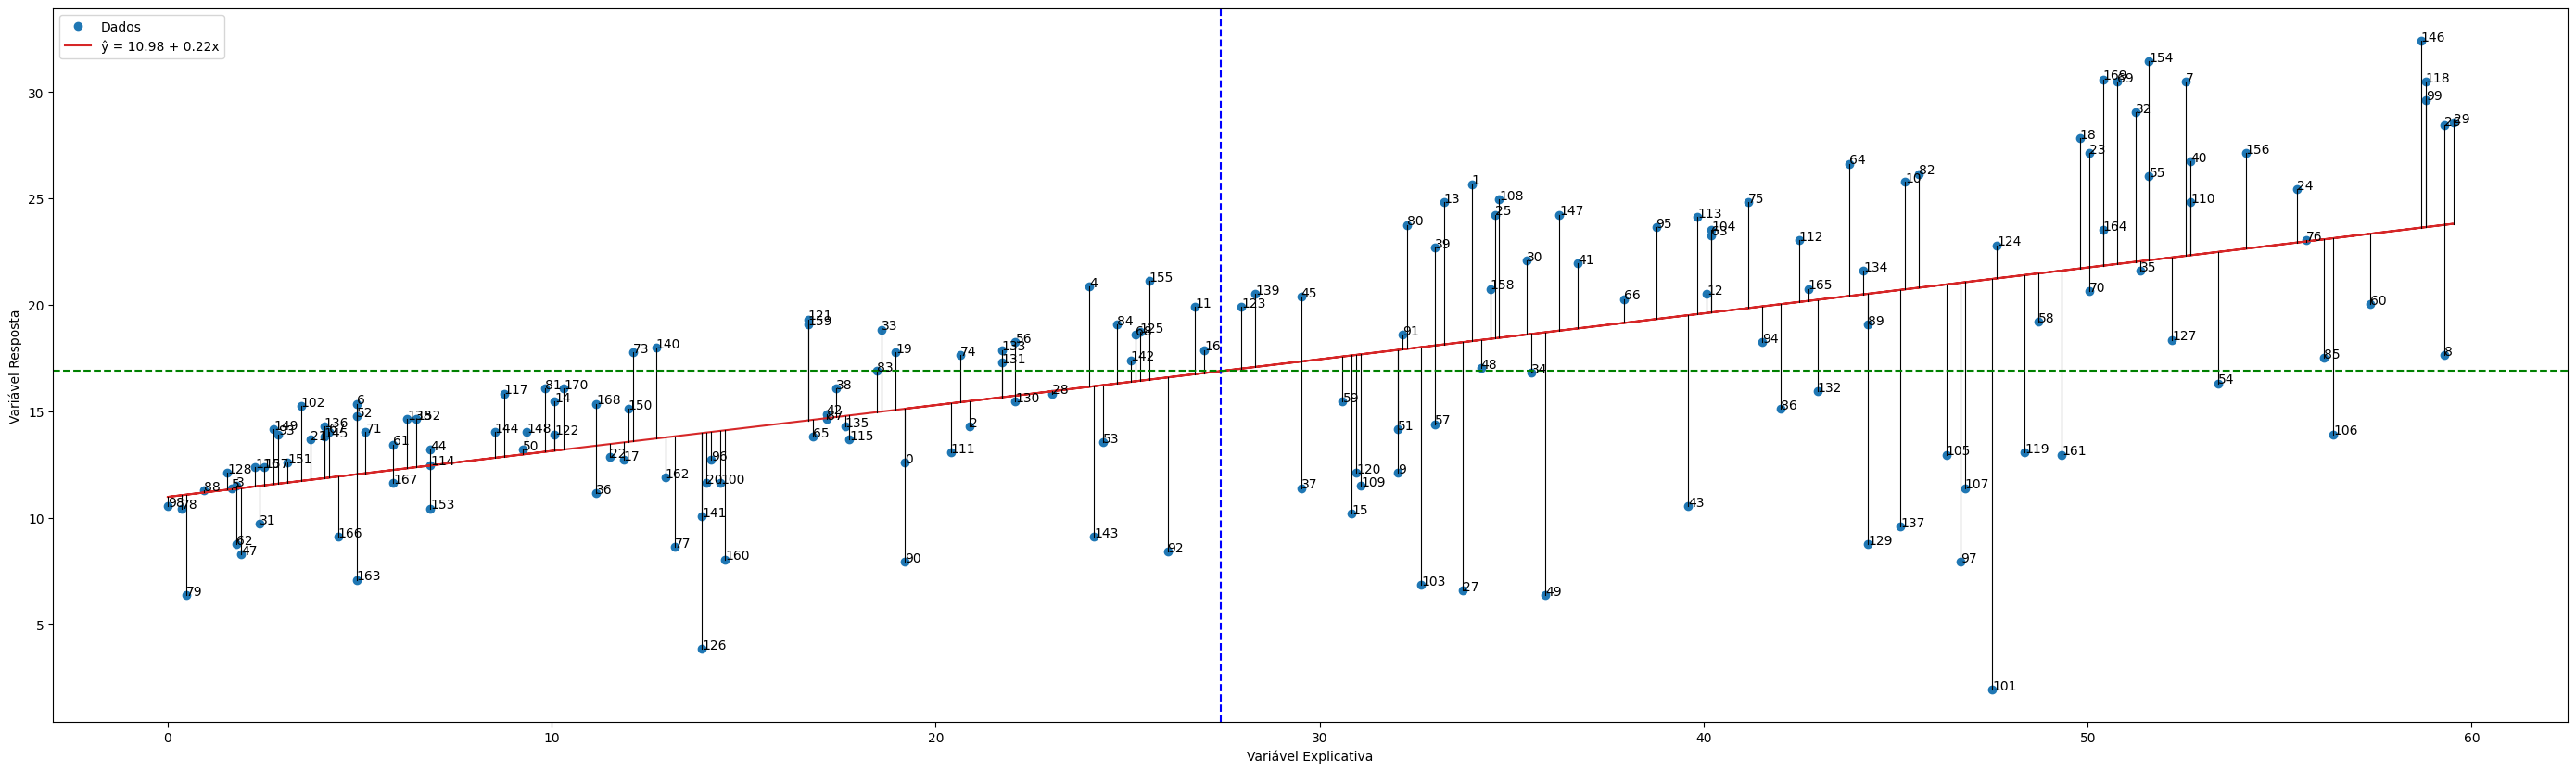

In [52]:
# Campo para selecionar trechos das observações para análises (número da observação e coordenadas dos vetores)
print(f"Obs. Coordenadas:\n{observacoes_coordenadas('facebook', 'sales', 1, 3)}")
# Plocar gráfico de dispersão com observações identificadas e valores para análise de linearidade:
grafico_dispersao(df['facebook'], df['sales'], 35, 10)

from scipy.stats import chi2_contingency

tabela = pd.crosstab(df_tabela['youtube'], df_tabela['sales'])
stat, p, dof, expected = chi2_contingency(tabela)
print(f"Estatística Qui-Quadrado: {stat}, p-valor: {p}, GL: {dof}")

/var/folders/q4/msgggjcn0c9448__nbm848r00000gn/T/ipykernel_28944/862903891.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




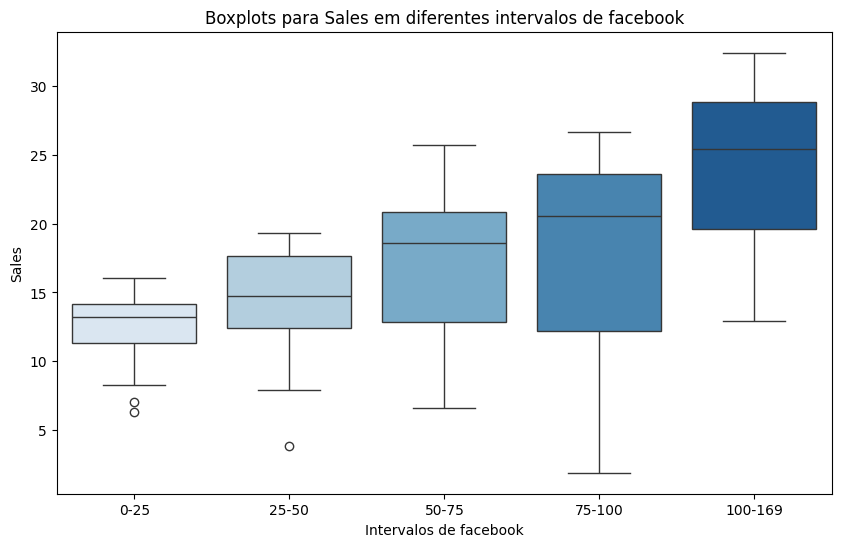

In [53]:
# Criando intervalos de 'youtube' para categorizar
df_cut['facebook_bins'] = pd.cut(df_cut['facebook'], bins=5, labels=["0-25", "25-50", "50-75", "75-100", "100-169"])
# Plotando o gráfico de boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cut, x='facebook_bins', y='sales', palette="Blues")
# Adicionando títulos e rótulos
plt.title("Boxplots para Sales em diferentes intervalos de facebook")
plt.xlabel("Intervalos de facebook")
plt.ylabel("Sales")
plt.show()

In [54]:
# Agrupando os dados por intervalo
grupos_facebook = [df_cut.loc[df_cut['facebook'] == bin, 'sales'] for bin in df_cut['facebook'].unique()]

# Teste de ANOVA
stat, p = f_oneway(*grupos_facebook)
print(f"Estatística F (ANOVA): {stat:.4f}, p-valor: {p:.4f}")

# Interpretação
if p < 0.05:
    print("Diferenças significativas entre os grupos.")
else:
    print("Não há diferenças significativas entre os grupos.")

Estatística F (ANOVA): 3.2893, p-valor: 0.0004
Diferenças significativas entre os grupos.


In [55]:
# Agrupando os dados por intervalo
grupos_facebook = [df_cut.loc[df_cut['facebook'] == bin, 'sales'] for bin in df_cut['facebook'].unique()]

# Teste de ANOVA
stat, p = f_oneway(*grupos_facebook)
print(f"Estatística F (ANOVA): {stat:.4f}, p-valor: {p:.4f}")

# Interpretação
if p < 0.05:
    print("Diferenças significativas entre os grupos.")
else:
    print("Não há diferenças significativas entre os grupos.")

Estatística F (ANOVA): 3.2893, p-valor: 0.0004
Diferenças significativas entre os grupos.


#### NEWSPAPER - SALES
- NEWSPAPER - VARIÁVEL PREDITORA
- SALES - VARIÁVEL RESPOSTA

In [56]:
# # Campo para selecionar as observações para análises (número da observação e coordenadas dos vetores)
# selecao_newspaper = selecao_observacao(df[['newspaper', 'sales']], [1]).sort_values(by='sales')

# print(f"Observações selecionadas (ordenadas por sales) para newspaper:\n{selecao_newspaper}")

Obs. Coordenadas:
       x      y
1  51.84  25.68
2  46.32  14.28
 
 | Coeficiente angular: 0.068 | Intercepto: 14.569 | Coeficiente de correlação: 0.254 | Valor-p (hipótese de inclinação): 0.00087 | Erro padrão de inclinação: 0.01997 


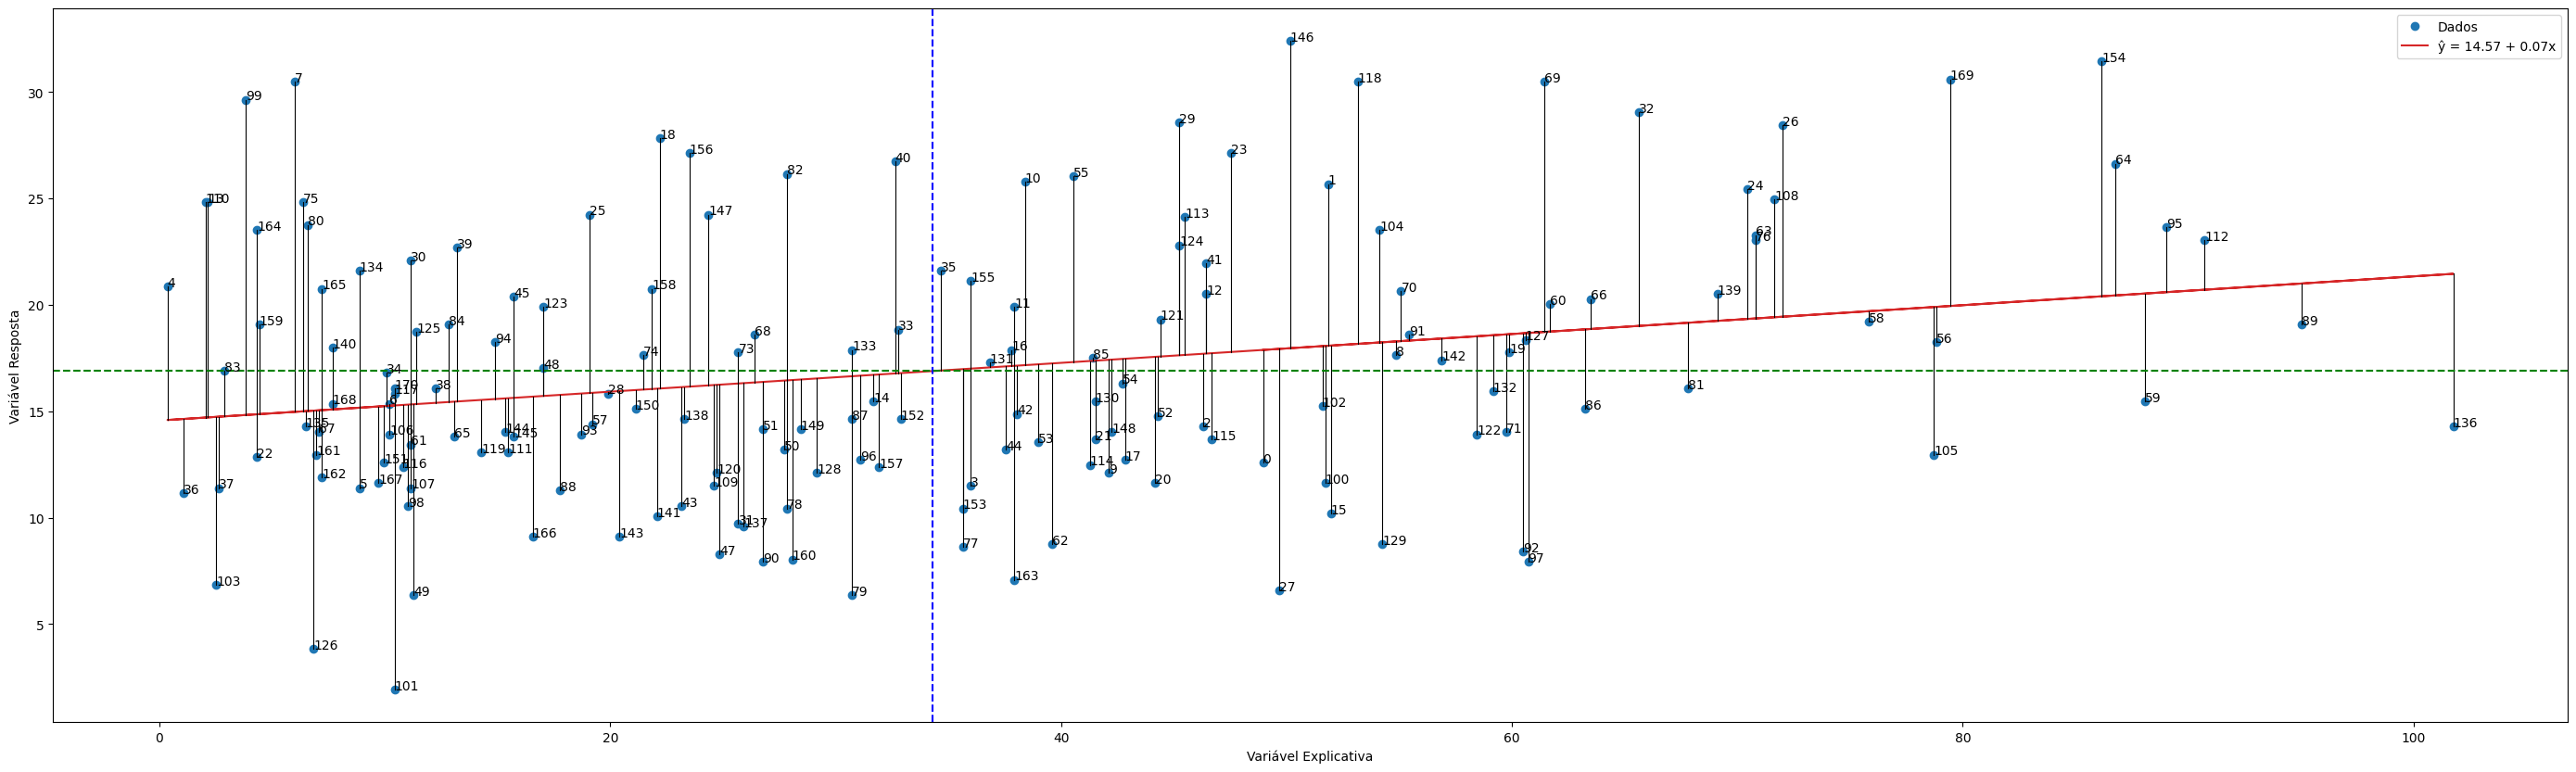

In [57]:
# Campo para selecionar trechos das observações para análises (número da observação e coordenadas dos vetores)
print(f"Obs. Coordenadas:\n{observacoes_coordenadas('newspaper', 'sales', 1, 3)}")
# Plocar gráfico de dispersão com observações identificadas e valores para análise de linearidade:
grafico_dispersao(df['newspaper'], df['sales'], 35, 10)

/var/folders/q4/msgggjcn0c9448__nbm848r00000gn/T/ipykernel_28944/4114718444.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




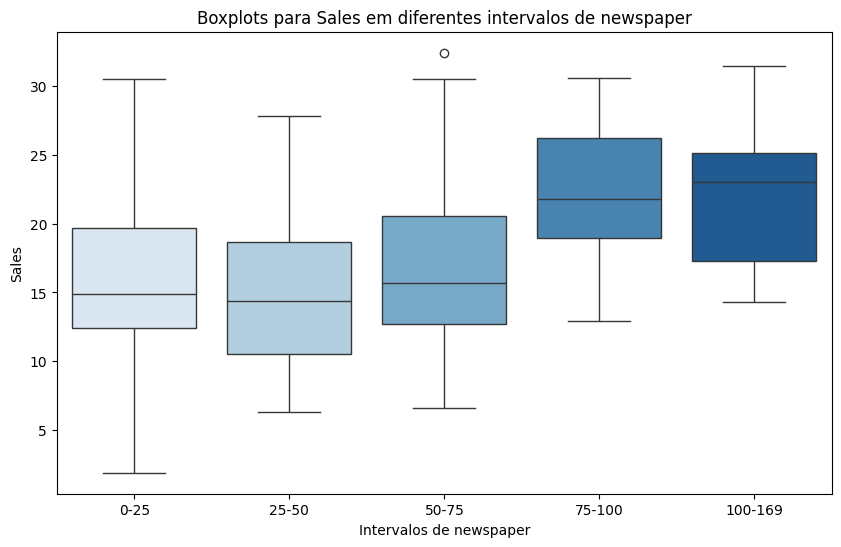

In [58]:
# Criando intervalos de 'newspaper' para categorizar
df_cut['newspaper_bins'] = pd.cut(df_cut['newspaper'], bins=5, labels=["0-25", "25-50", "50-75", "75-100", "100-169"])
# Plotando o gráfico de boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cut, x='newspaper_bins', y='sales', palette="Blues")
# Adicionando títulos e rótulos
plt.title("Boxplots para Sales em diferentes intervalos de newspaper")
plt.xlabel("Intervalos de newspaper")
plt.ylabel("Sales")
plt.show()

### ANÁLISE EXPLORATÓRIA DE DADOS (AED) - ANÁLISE MULTIVARIADA

#### ANÁLISE DE CORRELAÇÃO


Obeservações:
- Youtube é a variável mais relevante para explicar sales, seguido por facebook.
- Newspaper tem pouca contribuição para sales, e a análise de correlação reforça isso.

Correlação de Pearson

            youtube  facebook  newspaper     sales
youtube    1.000000  0.092200   0.110262  0.776382
facebook   0.092200  1.000000   0.270263  0.614581
newspaper  0.110262  0.270263   1.000000  0.253835
sales      0.776382  0.614581   0.253835  1.000000


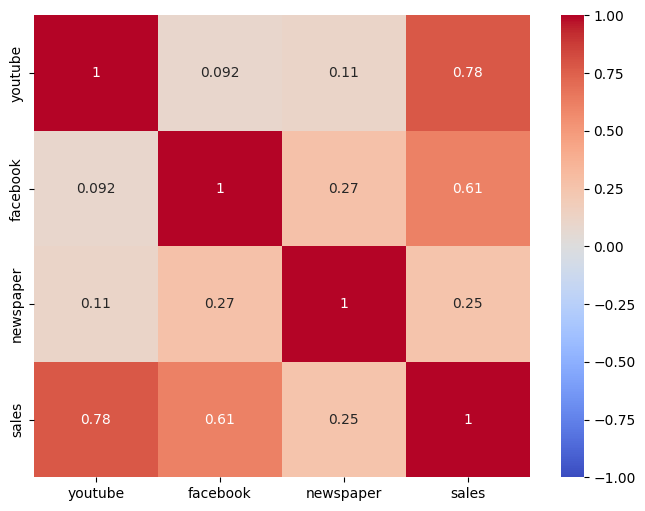

In [59]:
plt.figure(figsize=(8, 6))
# Aqui foi calculado a correlação de Pearson
corr_pearson = df.corr(method='pearson')
print(corr_pearson)
# Visualização da matriz da correlação de Pearson
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Correlação de Spearman

In [60]:
x_explicativo1 = df['youtube']
x_explicativo2 = df['newspaper']
# Realizando o cálculo da correlação de Spearman
corr, p_value = spearmanr(x_explicativo1, x_explicativo2)
print("Correlação de Spearman:", corr)
print("Valor-p:", p_value)

Correlação de Spearman: 0.0748779403934563
Valor-p: 0.3332702232067508


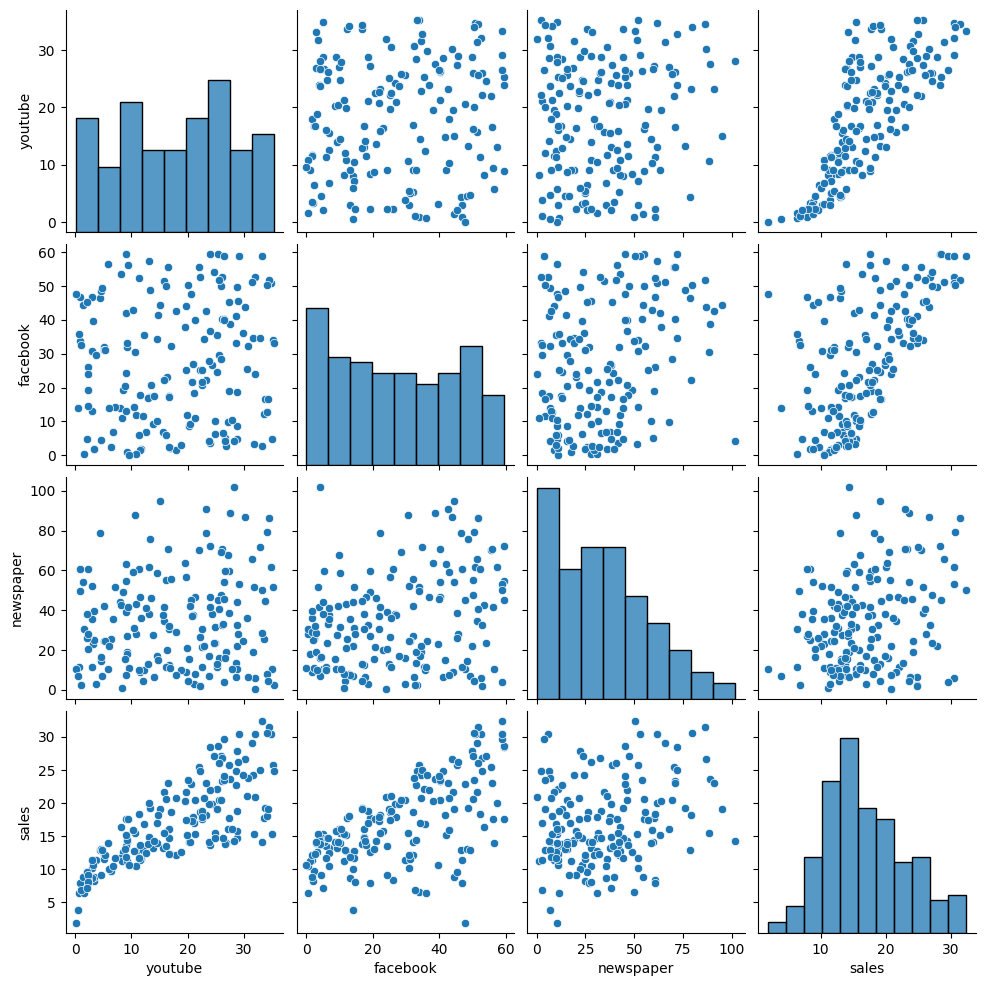

In [61]:
df_pairplot = df.copy()
sns.pairplot(df_pairplot)
plt.show()

#### ANÁLISE DE MULTICOLINEARIDADE

Observações:
- Não indícios de multicolinearidade e o VIF da constante não é preocupante.

In [62]:
# Calculando a VIF
df_mult = df.copy()
df_mult = pd.DataFrame(df_mult, columns=['youtube', 'facebook', 'newspaper'])

# Constante para o intercepto
X_constante = sm.add_constant(df_mult)

# Calculando o VIF (Fator de Inflação da Variância) para cada variável
vif = pd.DataFrame()
vif["Variável"] = X_constante.columns
vif["VIF"] = [variance_inflation_factor(X_constante.values, i) for i in range(X_constante.shape[1])]

print(vif)

    Variável       VIF
0      const  6.907218
1    youtube  1.016630
2   facebook  1.083405
3  newspaper  1.087415


#### ANÁLISE DE VARIÂNCIA PARCIAL

Observações:
- A análise reflete que youtube é a variável mais relevante para o modelo e que
facebook tem relevância moderada.
- Newspaper apresenta uma contribuição irrelevante e será excluído em análises posteriores para simplificar o modelo, dado seu impacto quase nulo.


In [63]:
# Variável dependente e variáveis independentes
X = df[['facebook', 'youtube', 'newspaper']]
y = df['sales']

# Constante β0 para o intercepto
X = sm.add_constant(X)

# Realização da divisão dos dados em dados de teste e dados de treino:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Modelo completo (facebook, youtube e newspaper)
modelo_completo = sm.OLS(y_train, X_train).fit()
r2_completo = modelo_completo.rsquared

# 2. Modelo com youtube e newspaper (sem facebook)
X_train_fb = X_train.drop(columns=['facebook'])
modelo_fb = sm.OLS(y_train, X_train_fb).fit()
r2_fb = modelo_fb.rsquared

# 3. Modelo com facebook e newspaper (sem youtube)
X_train_yt = X_train.drop(columns=['youtube'])
modelo_yt = sm.OLS(y_train, X_train_yt).fit()
r2_yt = modelo_yt.rsquared

# 4. Modelo com facebook e youtube (sem newspaper)
X_train_np = X_train.drop(columns=['newspaper'])
modelo_np = sm.OLS(y_train, X_train_np).fit()
r2_np = modelo_np.rsquared

# Realização do cálculo do R² parcial
# A contribuição de cada variável é a diferença entre o R² completo e o R² do modelo sem a variável
parcial_r2_youtube = r2_completo - r2_yt  # R² parcial para youtube
parcial_r2_facebook = r2_completo - r2_fb  # R² parcial para facebook
parcial_r2_newspaper = r2_completo - r2_np  # R² parcial para newspaper

print("R² do modelo completo:", r2_completo)
print("R² do modelo sem facebook:", r2_fb)
print("R² do modelo sem youtube:", r2_yt)
print("R² do modelo sem newspaper:", r2_np)
print("R² parcial para youtube:", parcial_r2_youtube)
print("R² parcial para facebook:", parcial_r2_facebook)
print("R² parcial para newspaper:", parcial_r2_newspaper)

R² do modelo completo: 0.8991905686118851
R² do modelo sem facebook: 0.6478172289555086
R² do modelo sem youtube: 0.36170533616225786
R² do modelo sem newspaper: 0.8983708040507177
R² parcial para youtube: 0.5374852324496272
R² parcial para facebook: 0.2513733396563764
R² parcial para newspaper: 0.0008197645611673909


##### ANÁLISE DE INTERAÇÃO ENTRE AS VARIÁVEIS EXPLICATIVAS

Observações:

1.	Interação significativa:

- O valor de  p  associado ao coeficiente de interação ($ \beta_3 $) é menor que 0.05 ($ \beta_3 = 0.0091 $), indicando evidência estatística de uma interação significativa entre as variáveis explicativas. 

- Isso sugere que o impacto de uma variável explicativa na variável dependente depende dos níveis da outra, reforçando a relevância do termo de interação no modelo.

2.	Alto Ajuste ( $ R^2 $):

- O alto valor de $ R^2 $ do modelo ajustado destaca a contribuição da interação entre as variáveis para melhorar o ajuste global.

- Esse resultado sugere que a inclusão do termo de interação não só é estatisticamente significativa, como também melhora a capacidade preditiva do modelo.



Singer, J. M., & Morettin, P. A. (2022).
Estatística e Ciência de Dados. São Paulo: Blucher.

- Modelo de regressão - Mínimos Quadrados Ordinários: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Ridge.html

In [64]:
# Incluindo o termo de interação
df['youtube_facebook_interaction'] = df['youtube'] * df['facebook']

# Incluindo as variáveis no modelo
X = sm.add_constant(df[['youtube', 'facebook', 'youtube_facebook_interaction']])
y = df['sales']

# Ajustando o modelo de regressão
model = sm.OLS(y, X).fit()

# Sumário do modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1603.
Date:                Sun, 24 Nov 2024   Prob (F-statistic):          9.55e-122
Time:                        18:46:23   Log-Likelihood:                -261.71
No. Observations:                 169   AIC:                             531.4
Df Residuals:                     165   BIC:                             543.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

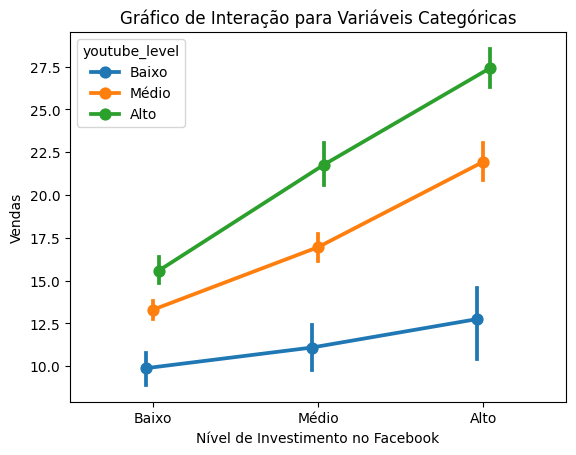

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar variáveis categóricas para faixas de YouTube e Facebook
df['youtube_level'] = pd.qcut(df['youtube'], q=3, labels=['Baixo', 'Médio', 'Alto'])
df['facebook_level'] = pd.qcut(df['facebook'], q=3, labels=['Baixo', 'Médio', 'Alto'])

# Plotar gráfico de interação invertido
sns.pointplot(data=df, x='facebook_level', y='sales', hue='youtube_level', dodge=True)
plt.title("Gráfico de Interação para Variáveis Categóricas")
plt.xlabel("Nível de Investimento no Facebook")
plt.ylabel("Vendas")
plt.show()

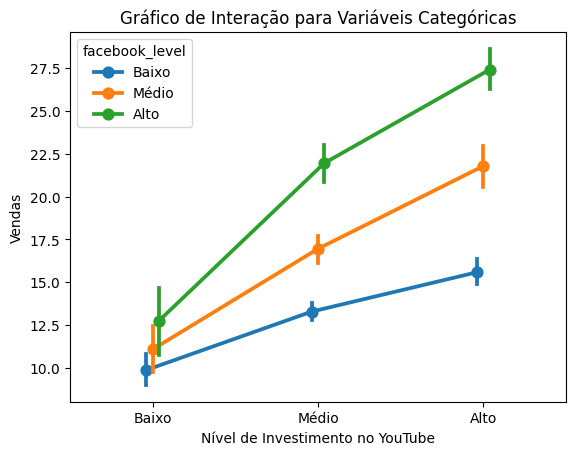

In [66]:
import seaborn as sns

# Criar variáveis categóricas para faixas de YouTube e Facebook
df['youtube_level'] = pd.qcut(df['youtube'], q=3, labels=['Baixo', 'Médio', 'Alto'])
df['facebook_level'] = pd.qcut(df['facebook'], q=3, labels=['Baixo', 'Médio', 'Alto'])

# Plotar gráfico de interação invertido
sns.pointplot(data=df, x='youtube_level', y='sales', hue='facebook_level', dodge=True)
plt.title("Gráfico de Interação para Variáveis Categóricas")
plt.xlabel("Nível de Investimento no YouTube")
plt.ylabel("Vendas")
plt.show()

# MODELAGEM

##### TRANSFORMAÇÃO E PRÉ-PROCESSAMENTO

Observações:
- Como evidenciado na análise, os dados apresentam relações não lineares que são possivelmente causadas pela interação entre as variáveis independentes. Para “capturar” essas relações não lineares, foram adicionados termos polinomiais de grau 2 e grau 3 às variáveis 
independentes.

- Um termo de interação foi incluído no modelo para melhorar o ajuste e representar os efeitos conjuntos entre as variáveis. Essa abordagem também contribuiu para a normalidade da distribuição dos resíduos e ajudou a mitigar a heterocedasticidade.

- Para lidar com as diferentes escalas das variáveis, foi aplicado o StandardScaler para realizar a normalização, garantindo que todas as variáveis tivessem a mesma unidade de escala.

- Alguns valores atípicos foram identificados como tendo alto valor de alavancagem, influenciando significativamente os coeficientes e a relação entre as variáveis. Esses valores foram removidos para evitar distorções nos resultados do modelo.

In [67]:
# Escalonamento com StandardScaler
scaler_youtube = StandardScaler()
df['youtube'] = scaler_youtube.fit_transform(df[['youtube']])
scaler_facebook = StandardScaler()
df['facebook'] = scaler_facebook.fit_transform(df[['facebook']])
scaler_sales = StandardScaler()
df['sales'] = scaler_sales.fit_transform(df[['sales']])
scaler_newspaper = StandardScaler()

# Criando os termos polinomiais e de interação
df['facebook_quadratico'] = df['facebook'] ** 2
df['facebook_cubico'] = df['facebook'] ** 3
df['youtube_quadratico'] = df['youtube'] ** 2
df['youtube_cubico'] = df['youtube'] ** 3
df['facebook_youtube_interacao'] = df['facebook'] * df['youtube']

# Retirada de valores atípicos com alto valor de alavancagem
df = df.drop([101,126,49,27,103,79,97,37,12,88,23])

#### ANÁLISE DE SUPOSIÇÕES DO MODELO

Observações: 

1.	Modelo escolhido:

- O primeiro modelo escolhido foi: 
 $
\hat{y} = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 z + \beta_5 z^2 + \beta_6 z^3 + \beta_7 (x \cdot z) + \epsilon
$

Onde:

- $ x $: representa o investimento em YouTube.
- $ z $: representa o investimento em Facebook.

Essa fórmula incorpora termos:
- Lineares: para modelar relações diretas.
- Polinomiais (grau 2 e 3): para capturar curvaturas e relações não lineares.
- De interação: para avaliar como os efeitos de $ x $ e $ z $ combinam-se na variável dependente ($ \hat{y} $, representando as vendas).

2.	Multicolinearidade:

- A adição de termos polinomiais e de interação resulta em forte correlação entre essas novas variáveis e as variáveis originais ($ x, z $).
- Isso pode gerar multicolinearidade, que provoca coeficientes instáveis no modelo de Mínimos Quadrados Ordinários (OLS), prejudicando a capacidade de generalização.

3.	Overfitting:

- A inclusão de muitos termos (como os cúbicos e de interação) aumenta o risco de overfitting, onde o modelo se ajusta excessivamente aos dados de treinamento, comprometendo o desempenho em novos dados (teste).

4.	Regularização:

- Para lidar com os problemas de multicolinearidade e overfitting, será discutido o uso de regularização, como:
- Ridge: que penaliza coeficientes grandes, reduzindo a instabilidade.
- Lasso: que elimina coeficientes irrelevantes, simplificando o modelo.
- Essas técnicas ajudam a melhorar a generalização do modelo, equilibrando viés e variância.



Singer, J. M., & Morettin, P. A. (2022).
Estatística e Ciência de Dados. São Paulo: Blucher.

- Modelo de regressão - Mínimos Quadrados Ordinários: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Ridge.html

In [68]:
# Criando os termos polinomiais e de interação
df['facebook_quadratico'] = df['facebook'] ** 2
df['facebook_cubico'] = df['facebook'] ** 3
df['youtube_quadratico'] = df['youtube'] ** 2
df['youtube_cubico'] = df['youtube'] ** 3
df['facebook_youtube_interacao'] = df['facebook'] * df['youtube']

# Variáveis independentes, interação, e termos polinomiais
X = df[['facebook', 'facebook_quadratico', 'facebook_cubico',
        'youtube', 'youtube_quadratico', 'youtube_cubico',
        'facebook_youtube_interacao']]
X = sm.add_constant(X)  # Incluindo o intercepto
y = df['sales']  # Variável dependente original

# Divisão entre variáveis independentes e dependente
X = df[['facebook', 'facebook_quadratico', 'facebook_cubico',
        'youtube', 'youtube_quadratico', 'youtube_cubico',
        'facebook_youtube_interacao']]
X = sm.add_constant(X)  # Incluindo o intercepto
y = df['sales']  # Variável dependente

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustando o modelo nos dados de treino
modelo_OLS = sm.OLS(y_train, X_train).fit()

# Avaliação no conjunto de treino
y_train_pred = modelo_OLS.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Avaliação no conjunto de teste
y_test_pred = modelo_OLS.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(modelo_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     5739.
Date:                Sun, 24 Nov 2024   Prob (F-statistic):          2.94e-146
Time:                        18:46:24   Log-Likelihood:                 198.64
No. Observations:                 126   AIC:                            -381.3
Df Residuals:                     118   BIC:                            -358.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Observação:
- É importante ressaltar que os valores foram transformados para um melhor ajuste do modelo, porém para avaliar os resultados é necessário que os valores sejam alterados para os valores originais conforme feito abaixo

In [69]:
# Reverter coeficientes e intercepto para a escala original
coefs_scaled = modelo_OLS.params
intercept_scaled = coefs_scaled[0]  # O intercepto é o primeiro coeficiente
coefs_scaled = coefs_scaled[1:]  # Demais coeficientes

# Obter escaladores para variáveis independentes e dependente
scaler_X = [scaler_facebook, scaler_facebook, scaler_facebook, 
            scaler_youtube, scaler_youtube, scaler_youtube, 
            scaler_sales]  # Adaptar à ordem das variáveis no modelo
scaler_Y = scaler_sales

# Reverter coeficientes e intercepto
coefs_original = coefs_scaled.values * scaler_Y.scale_ / np.array([s.scale_[0] for s in scaler_X])
intercept_original = intercept_scaled * scaler_Y.scale_ + scaler_Y.mean_ - np.sum(
    (coefs_scaled.values * scaler_Y.scale_ * np.array([s.mean_[0] for s in scaler_X])) / np.array([s.scale_[0] for s in scaler_X])
)

print("\nCoeficientes do modelo na escala original:")
print("Intercepto:", intercept_original)
print("Coeficientes:", coefs_original)


Coeficientes do modelo na escala original:
Intercepto: [2.42051469]
Coeficientes: [ 0.18752633 -0.00111003  0.0042165   0.36492945 -0.07265046  0.0307123
  0.24851028]


/var/folders/q4/msgggjcn0c9448__nbm848r00000gn/T/ipykernel_28944/3273954697.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [70]:
# Reverter predições para a escala original
y_test_original = scaler_sales.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
y_test_pred_original = scaler_sales.inverse_transform(y_test_pred.values.reshape(-1, 1)).flatten()

# Comparação de valores observados e preditos no conjunto de teste
comparacao_ols_original = pd.DataFrame({
    'Valores observados (originais)': y_test_original,
    'Valores preditos (OLS, originais)': y_test_pred_original
})

print("Comparação entre valores observados e preditos (Modelo OLS, Valores Originais):")
print(comparacao_ols_original.head())

Comparação entre valores observados e preditos (Modelo OLS, Valores Originais):
   Valores observados (originais)  Valores preditos (OLS, originais)
0                           10.08                          10.595203
1                           14.16                          14.242303
2                           24.24                          24.031664
3                           30.60                          30.563122
4                           11.64                          11.247935


##### LINEARIDADE

In [71]:
# Realização do Teste de Ramsey RESET
reset_test = linear_reset(modelo_OLS, power=2)

print("\nResultado do Teste de Ramsey:")
print("Estatística F:", reset_test.statistic)
print("p-valor:", reset_test.pvalue)


Resultado do Teste de Ramsey:
Estatística F: 2.742805244037987
p-valor: 0.09769313161347117


##### NORMALIDADE DOS RESÍDUOS

In [72]:
# Calcular os resíduos do modelo OLS
residuos_ols = modelo_OLS.resid

# Teste de Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuos_ols, 'norm', args=(residuos_ols.mean(), residuos_ols.std()))
nome_ks = ["Estatística do Teste de Kolmogorov-Smirnov", "p-valor"]
valores_ks = [stat_ks, p_value_ks]

# Teste de Shapiro-Wilk
stat_sw, p_value_sw = shapiro(residuos_ols)
nome_sw = ["Estatística do Teste de Shapiro-Wilk", "p-valor"]
valores_sw = [stat_sw, p_value_sw]

# Resultados em DataFrame
resultados_ks_df = pd.DataFrame({"Medida": nome_ks, "Valor": valores_ks})
resultados_sw_df = pd.DataFrame({"Medida": nome_sw, "Valor": valores_sw})

print("Resultados do Teste de Kolmogorov-Smirnov:")
print(resultados_ks_df)
print("\nResultados do Teste de Shapiro-Wilk:")
print(resultados_sw_df)

# Interpretação dos testes
alpha = 0.05  # Nível de significância


Resultados do Teste de Kolmogorov-Smirnov:
                                       Medida     Valor
0  Estatística do Teste de Kolmogorov-Smirnov  0.050792
1                                     p-valor  0.884573

Resultados do Teste de Shapiro-Wilk:
                                 Medida     Valor
0  Estatística do Teste de Shapiro-Wilk  0.987332
1                               p-valor  0.295439


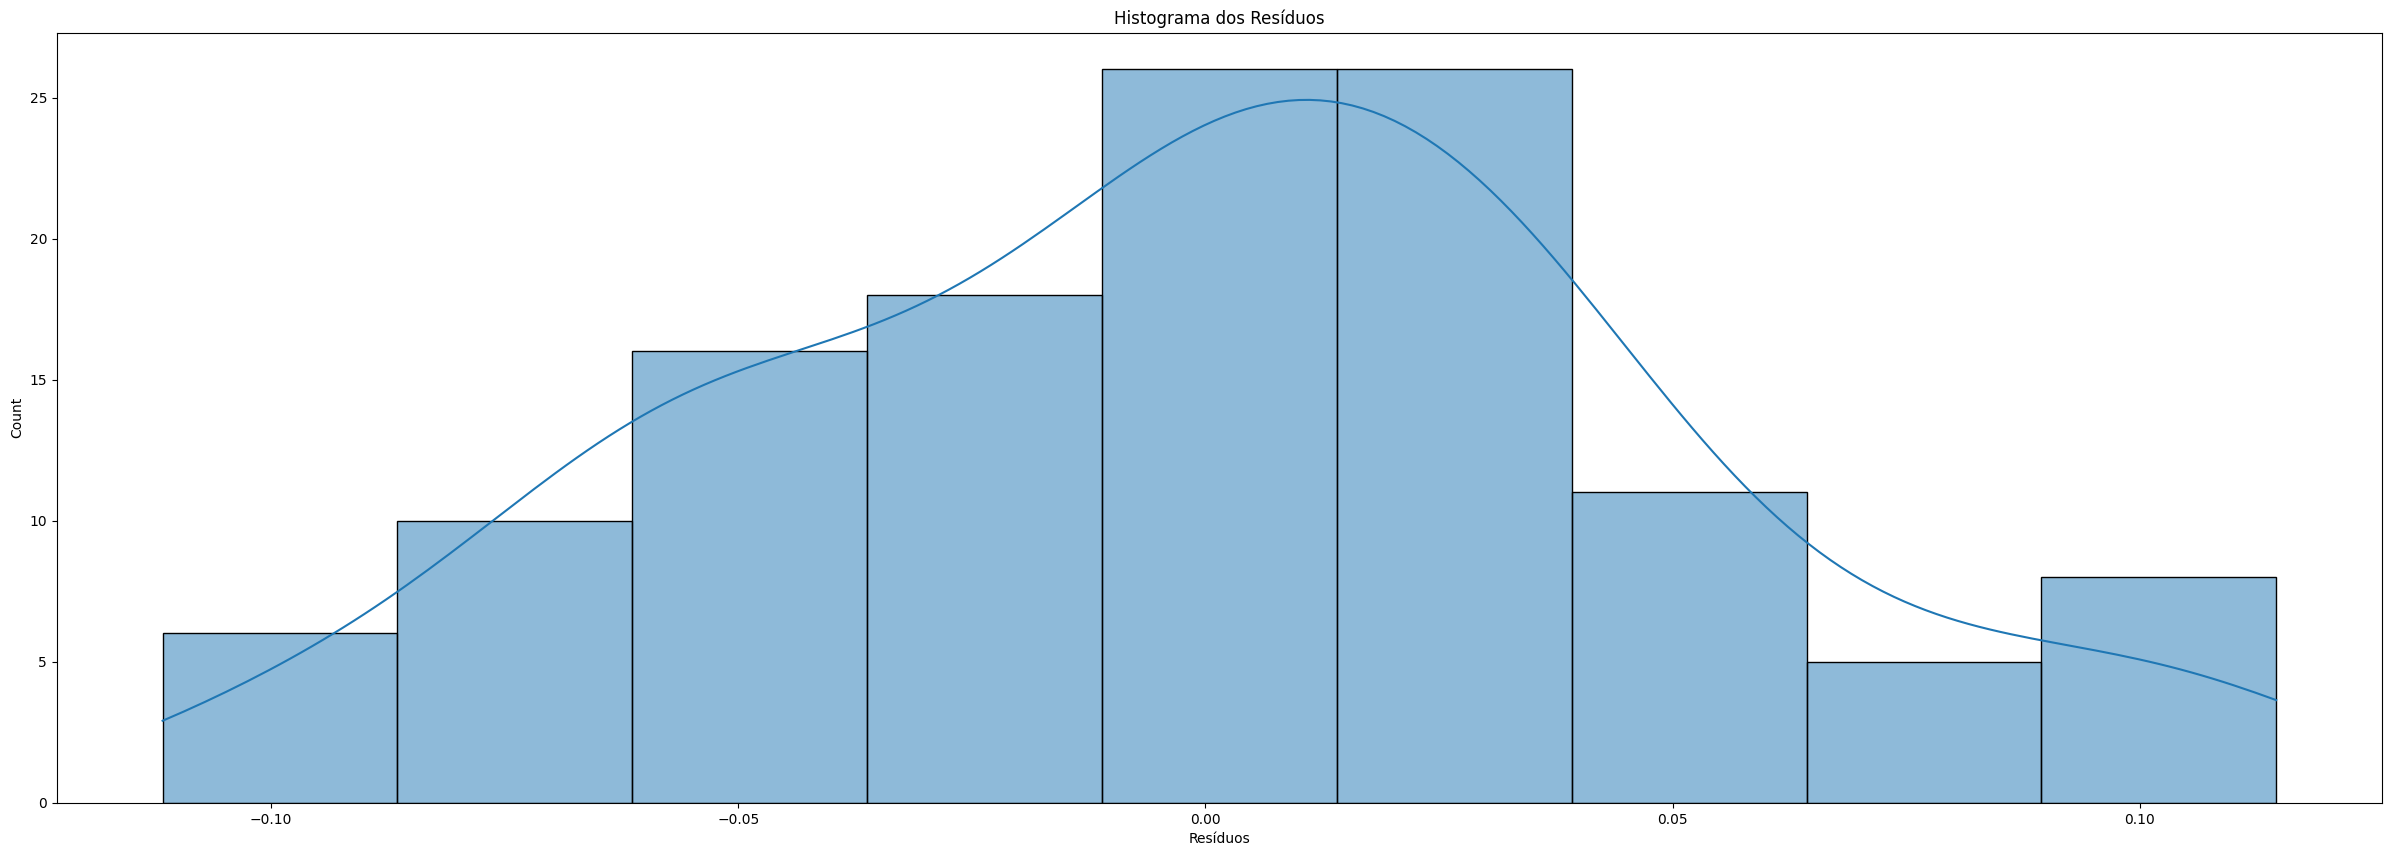

In [73]:
# Histograma dos Resíduos
plt.figure(figsize=(30, 10))
sns.histplot(modelo_OLS.resid, kde=True)
plt.xlabel('Resíduos')
plt.title('Histograma dos Resíduos')
plt.show()

##### ANÁLISE DE HETEROCEDASTICIDADE E MULTICOLINEARIDADE

In [74]:
# VIF
# Incluindo o intercepto
X = sm.add_constant(df[['facebook', 'facebook_quadratico', 'facebook_cubico',
                        'youtube', 'youtube_quadratico', 'youtube_cubico',
                        'facebook_youtube_interacao']])

# Calcular VIF
vif_data = pd.DataFrame()
vif_data["Variável"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                     Variável       VIF
0                       const  3.753517
1                    facebook  6.696424
2         facebook_quadratico  1.201375
3             facebook_cubico  7.124397
4                     youtube  5.548266
5          youtube_quadratico  1.068798
6              youtube_cubico  5.660768
7  facebook_youtube_interacao  1.027823


Teste de Breusch-Pagan: heteroscedasticidade linear em relação às variáveis independentes

- Teste de Breusch-Pagan: https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html

- Teste de Goldfeld-Quandt: https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_goldfeldquandt.html#statsmodels.stats.diagnostic.het_goldfeldquandt

- Teste de White: https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_white.html#statsmodels.stats.diagnostic.het_white


In [75]:
# Teste de hipótese - Breusch-Pagan
nome = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(modelo_OLS.resid, modelo_OLS.model.exog)
resultados_df = pd.DataFrame({"Estatística": nome, "Valor": test})
print(resultados_df)

                     Estatística     Valor
0  Lagrange multiplier statistic  4.959150
1                        p-value  0.664949
2                        f-value  0.690652
3                      f p-value  0.679777


Teste de Goldfeld-Quandt: heteroscedasticidade em relação a uma variável específica

In [76]:
# Teste de hipótese - Goldfeld-Quandt
nome = ["Lagrange multiplier statistic", "p-value", "f-value"]
test_gold = sms.het_goldfeldquandt(modelo_OLS.resid, modelo_OLS.model.exog)
resultados_df = pd.DataFrame({"Estatística": nome, "Valor": test_gold })
print(resultados_df)

                     Estatística       Valor
0  Lagrange multiplier statistic    1.465218
1                        p-value    0.079884
2                        f-value  increasing


Teste de White: heteroscedasticidade sem suposições específicas - teste menos robusto

In [77]:
# Teste de hipótese - White            z
nome = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
white_test = het_white(modelo_OLS.resid, modelo_OLS.model.exog)
resultados_df = pd.DataFrame({"Estatística": nome, "Valor": white_test })
print(resultados_df)

                     Estatística      Valor
0  Lagrange multiplier statistic  32.224353
1                        p-value   0.095567
2                        f-value   1.523935
3                      f p-value   0.079408


##### ANÁLISE DE INDEPENDÊNCIA DOS RESÍDUOS

In [78]:
# Teste de Breusch-Godfrey
bg_test = acorr_breusch_godfrey(modelo_OLS, nlags=4)  # nlags define a ordem máxima da autocorrelação testada
print("Estatístico de Breusch-Godfrey:", bg_test[0])
print("p-valor:", bg_test[1])

Estatístico de Breusch-Godfrey: 4.905070537080234
p-valor: 0.29717727077850564


In [79]:
# Teste de ljungbox
# Obtenha os resíduos do modelo
residuals = modelo_OLS.resid

# Realize o teste de Ljung-Box nos resíduos
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)  # lags define a ordem máxima da autocorrelação testada
print(ljung_box_test)

     lb_stat  lb_pvalue
10  9.379146   0.496539


In [80]:
# Teste de Wald-Wolfowitz
run_test = runstest_1samp(residuals)
print("Estatístico do Teste de Wald-Wolfowitz:", run_test[0])
print("p-valor:", run_test[1])

Estatístico do Teste de Wald-Wolfowitz: -1.2117296329288854
p-valor: 0.2256158919607162


#### ANÁLISE DE RUBUSTEZ

##### VALIDAÇÃO CRUZADA - DIVISÃO DOS DADOS EM CONJUNTO DE TESTE E TREINO

In [81]:
# Resultados
print("Desempenho do modelo:")
print(f"R² (Treino): {r2_train:.4f}")
print(f"R² (Teste): {r2_test:.4f}")
print(f"MSE (Treino): {mse_train:.4f}")
print(f"MSE (Teste): {mse_test:.4f}")

# Comparação entre treino e teste
print("\nDiferença entre os conjuntos de treino e teste:")
print(f"R² Treino - Teste: {r2_train - r2_test:.4f}")
print(f"MSE Treino - Teste: {mse_train - mse_test:.4f}")

Desempenho do modelo:
R² (Treino): 0.9971
R² (Teste): 0.9954
MSE (Treino): 0.0025
MSE (Teste): 0.0047

Diferença entre os conjuntos de treino e teste:
R² Treino - Teste: 0.0017
MSE Treino - Teste: -0.0022


In [82]:
# Configuração para validação cruzada com 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Listas para armazenar os resultados
r2_scores = []
mse_scores = []

# Loop para realizar a validação cruzada
for train_index, test_index in kf.split(X, y):
    # Dividindo os dados em treino e teste para cada fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ajustando o modelo nos dados de treino
    modelo_cv = sm.OLS(y_train, X_train).fit()

    # Previsão nos dados de teste
    y_pred = modelo_cv.predict(X_test)

    # Calculando R² e MSE para cada fold
    r2_scores.append(modelo_cv.rsquared)
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Resultados médios e desvio padrão
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

# Exibindo os resultados
print(f"Validação Cruzada - R² Médio: {mean_r2:.4f} (±{std_r2:.4f})")
print(f"Validação Cruzada - MSE Médio: {mean_mse:.4f} (±{std_mse:.4f})")


Validação Cruzada - R² Médio: 0.9968 (±0.0002)
Validação Cruzada - MSE Médio: 0.0033 (±0.0011)


#### ANÁLISE DE RESÍDUOS

##### ANÁLISE GRÁFICA DOS RESÍDUOS

- Gráficos de regressão: https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html

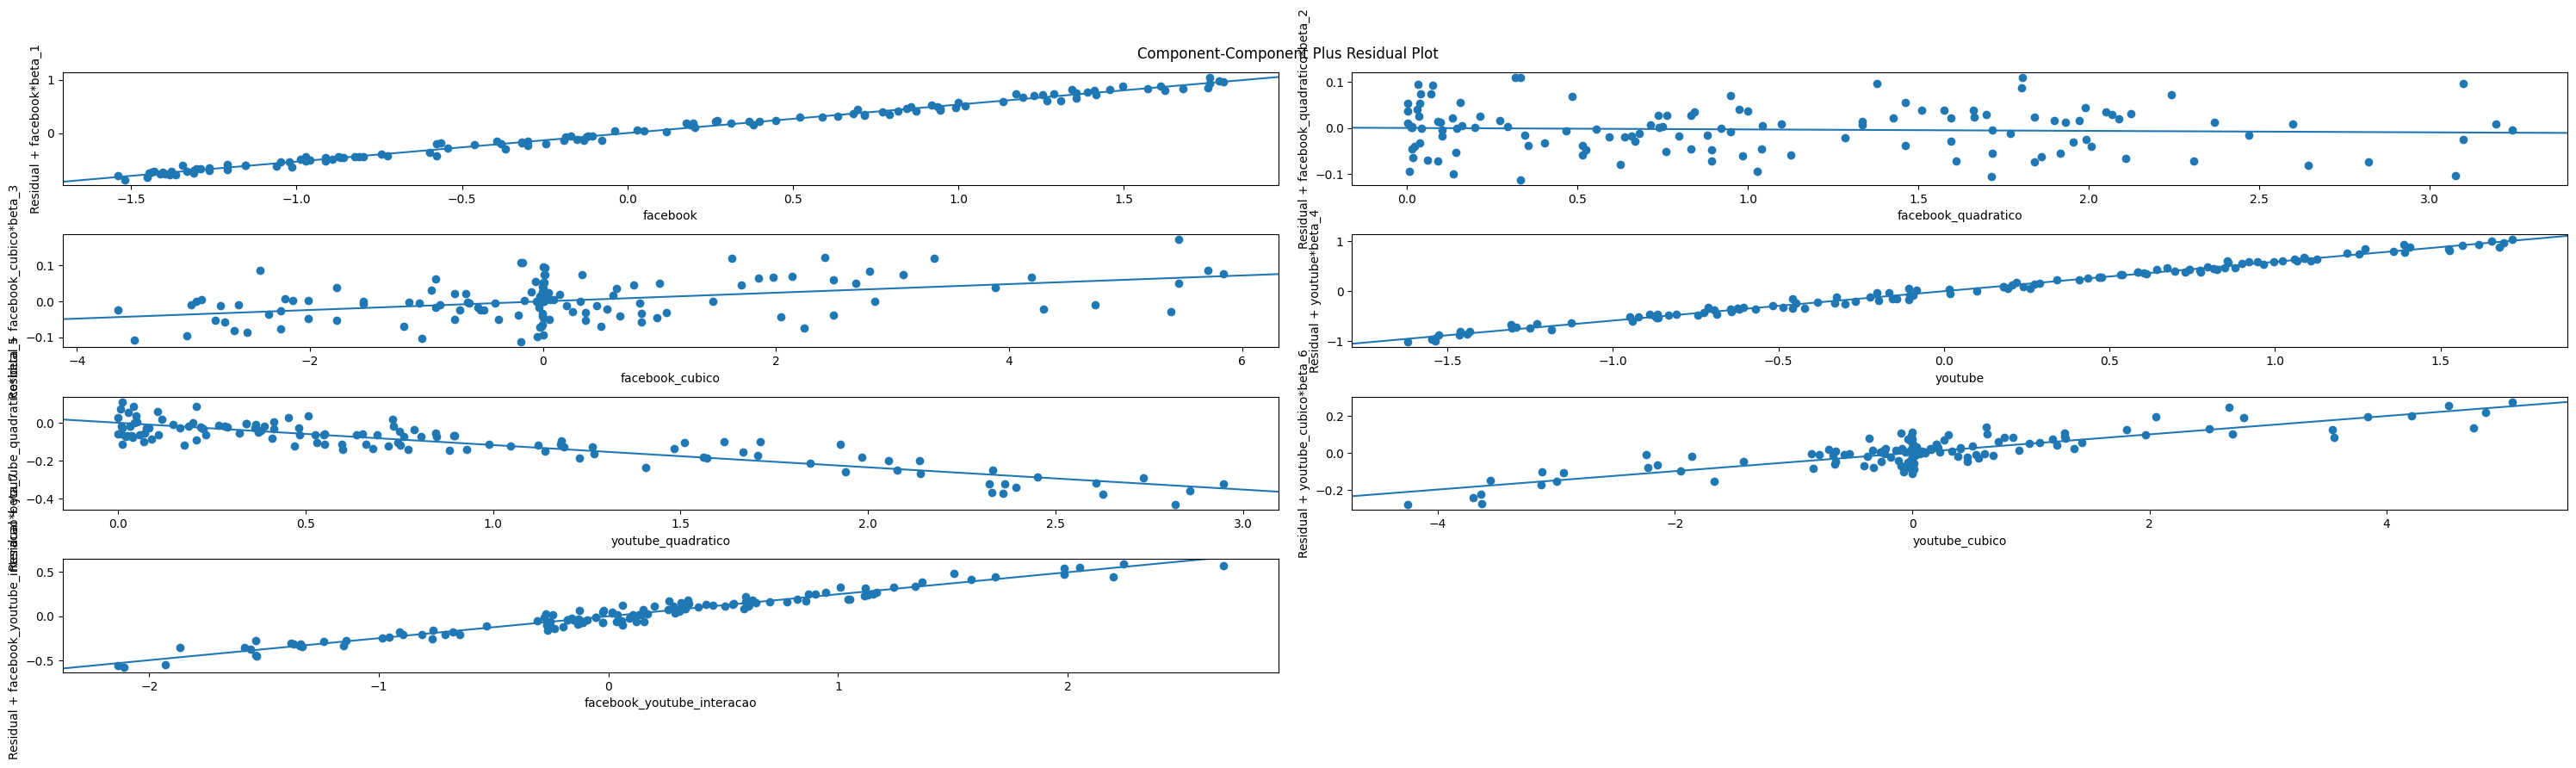

In [83]:
# Gráficos de resíduos
fig = sm.graphics.plot_ccpr_grid(modelo_OLS)
fig.set_size_inches(30, 8)
fig.tight_layout(pad=1.0)

- Gráficos de regressão: https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html

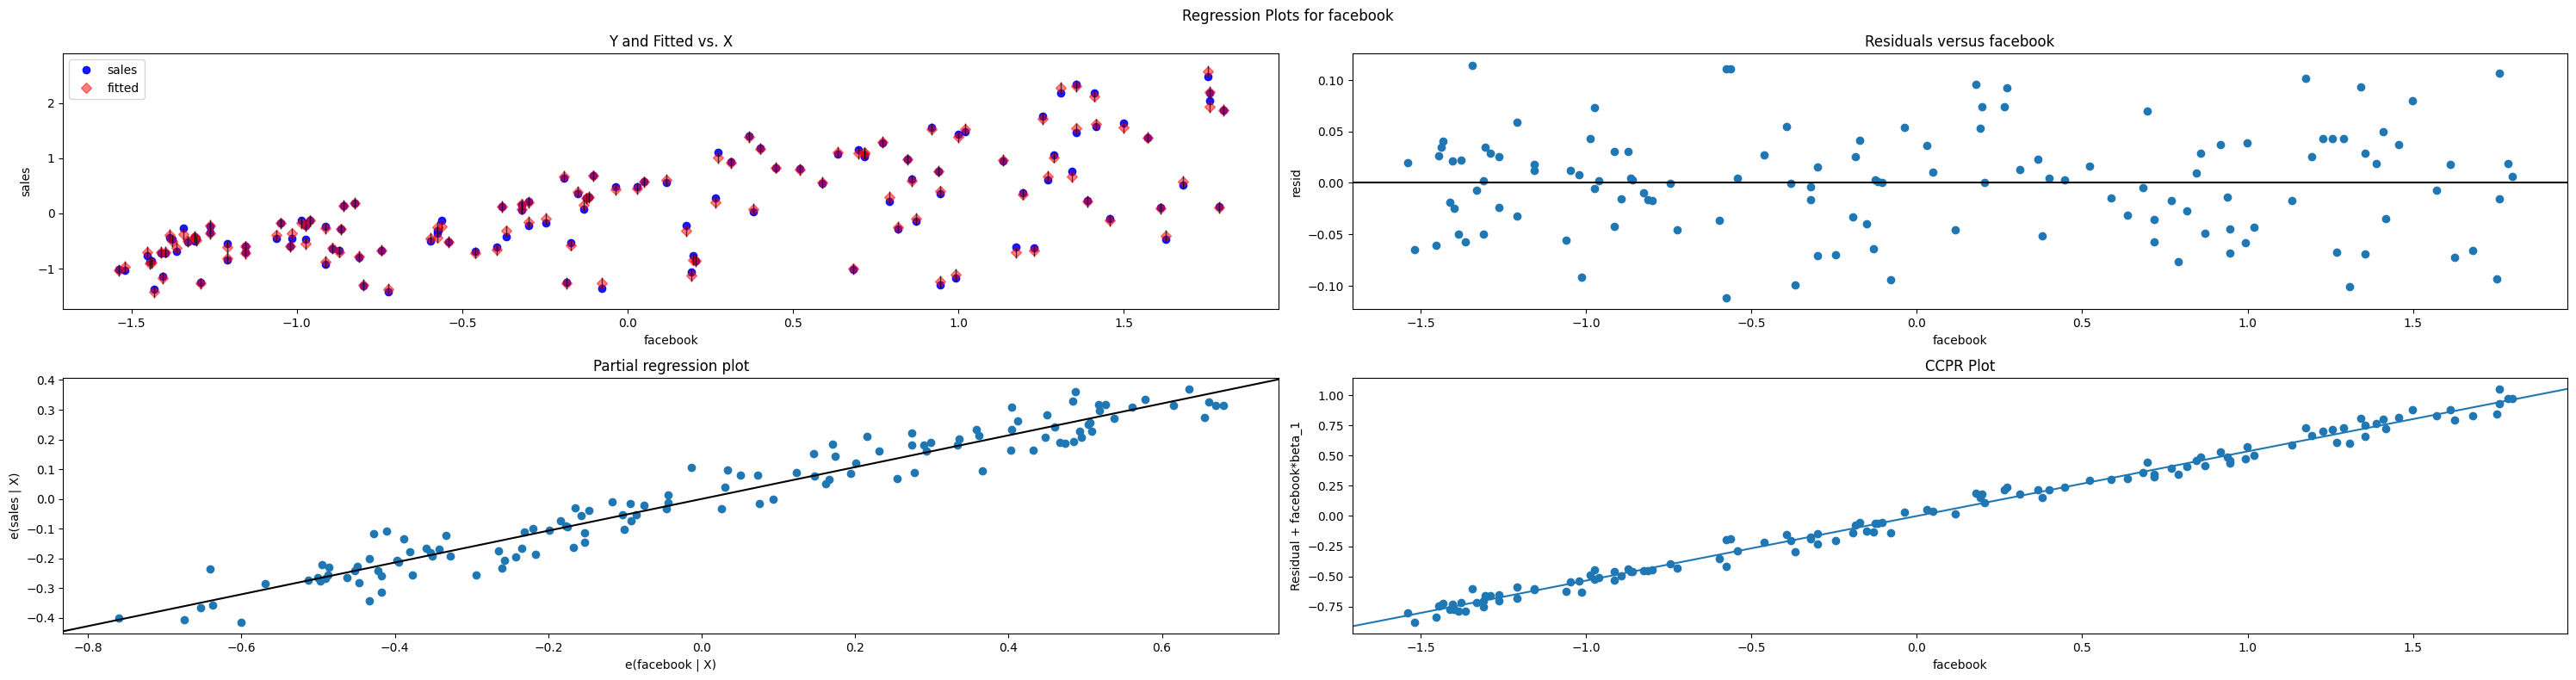

In [84]:
# Gráficos de resíduos

fig = sm.graphics.plot_regress_exog(modelo_OLS, "facebook")
fig.set_size_inches(30, 8)
fig.tight_layout(pad=1.0)

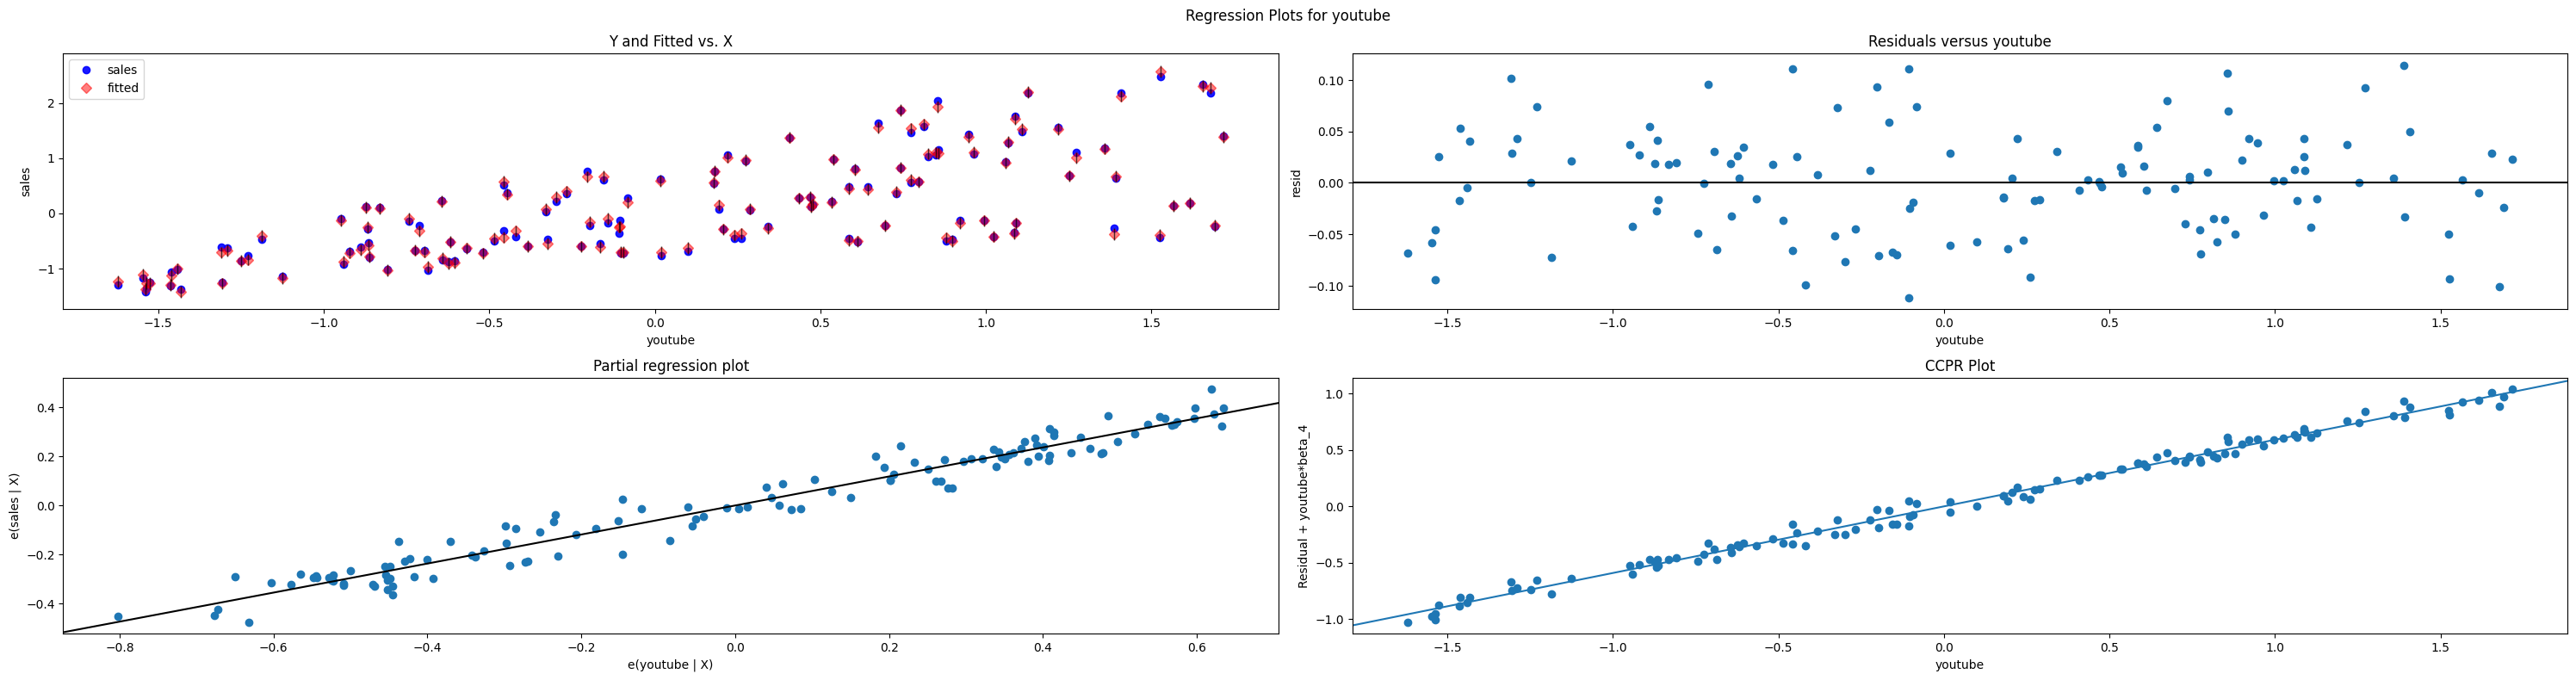

In [85]:
# Gráficos de resíduos
fig = sm.graphics.plot_regress_exog(modelo_OLS, "youtube")
fig.set_size_inches(30, 8)
fig.tight_layout(pad=1.0)

##### ANÁLISE DE SENSIBILIDADE DOS RESÍDUOS - DISTÂNCIA DE COOK, ALAVANCAGEM E INFLUÊNCIA

In [86]:
p = modelo_OLS.df_model  # Número de preditores
n = modelo_OLS.nobs

Distância de Cook - identificar pontos influentes

In [87]:
# Distância de Cook
influence = modelo_OLS.get_influence()
cooks_d = influence.cooks_distance[0]

# Imprimir observações com Distância de Cook acima de 0.5
print("Observações com Distância de Cook acima de 0.5:")
for i, val in enumerate(cooks_d):
    if val > 0.5:
        print(f"Observação {i}: Distância de Cook = {val:.4f}")


Observações com Distância de Cook acima de 0.5:


Alavancagem - identificar pontos que podem estar distorcendo a relação entre as variáveis.

In [88]:
# Alavancagem
# Definindo o limite de alavancagem
p = modelo_OLS.df_model  # Número de preditores
n = modelo_OLS.nobs      # Número de observações
leverage_threshold = 2 * (p + 1) / n

# Imprimir observações com Alavancagem acima do limite
leverage = influence.hat_matrix_diag
print("Observações com Alavancagem acima do limite ideal:")
for i, val in enumerate(leverage):
    if val > leverage_threshold:
        print(f"Observação {i}: Alavancagem = {val:.4f}")

Observações com Alavancagem acima do limite ideal:
Observação 5: Alavancagem = 0.1597
Observação 8: Alavancagem = 0.1508
Observação 9: Alavancagem = 0.1367
Observação 15: Alavancagem = 0.1846
Observação 16: Alavancagem = 0.1500
Observação 23: Alavancagem = 0.1278
Observação 31: Alavancagem = 0.1292
Observação 75: Alavancagem = 0.1358
Observação 80: Alavancagem = 0.1324
Observação 81: Alavancagem = 0.1673
Observação 91: Alavancagem = 0.1843
Observação 96: Alavancagem = 0.1610
Observação 110: Alavancagem = 0.1665
Observação 115: Alavancagem = 0.1614
Observação 122: Alavancagem = 0.1398


DFFITS - identificar pontos que têm um grande impacto nas previsões individuais.

In [89]:
# DFFITS
# Definindo o limite para DFFITS
dffits_threshold = 2 * np.sqrt((p + 1) / n)

# Imprimir observações com DFFITS acima do limite ideal
dffits = influence.dffits[0]
print("Observações com DFFITS acima do limite ideal:")
for i, val in enumerate(dffits):
    if abs(val) > dffits_threshold:
        print(f"Observação {i}: DFFITS = {val:.4f}")


Observações com DFFITS acima do limite ideal:
Observação 15: DFFITS = -0.9624
Observação 60: DFFITS = -0.5697
Observação 76: DFFITS = 0.7889
Observação 77: DFFITS = -0.6696
Observação 80: DFFITS = 0.8790
Observação 96: DFFITS = -0.9459
Observação 98: DFFITS = 0.6111
Observação 115: DFFITS = -0.6390


Resíduos Studentizados - identificar observações que não se ajustam bem ao modelo.

In [90]:
# Obtenção dos resíduos padronizados e studentizados
studentized_residuals = influence.resid_studentized_external

# Imprimir observações com Resíduos Studentizados Externos acima de 2 ou abaixo de -2
print("Observações com Resíduos Studentizados Externos acima de 2 ou abaixo de -2:")
for i, val in enumerate(studentized_residuals):
    if abs(val) > 2:
        print(f"Observação {i}: Resíduo Studentizado Externo = {val:.4f}")

Observações com Resíduos Studentizados Externos acima de 2 ou abaixo de -2:
Observação 15: Resíduo Studentizado Externo = -2.0227
Observação 18: Resíduo Studentizado Externo = -2.2335
Observação 70: Resíduo Studentizado Externo = 2.2240
Observação 76: Resíduo Studentizado Externo = 2.3817
Observação 80: Resíduo Studentizado Externo = 2.2500
Observação 88: Resíduo Studentizado Externo = 2.2190
Observação 96: Resíduo Studentizado Externo = -2.1596
Observação 98: Resíduo Studentizado Externo = 2.0779


- Gráficos de regressão: https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html

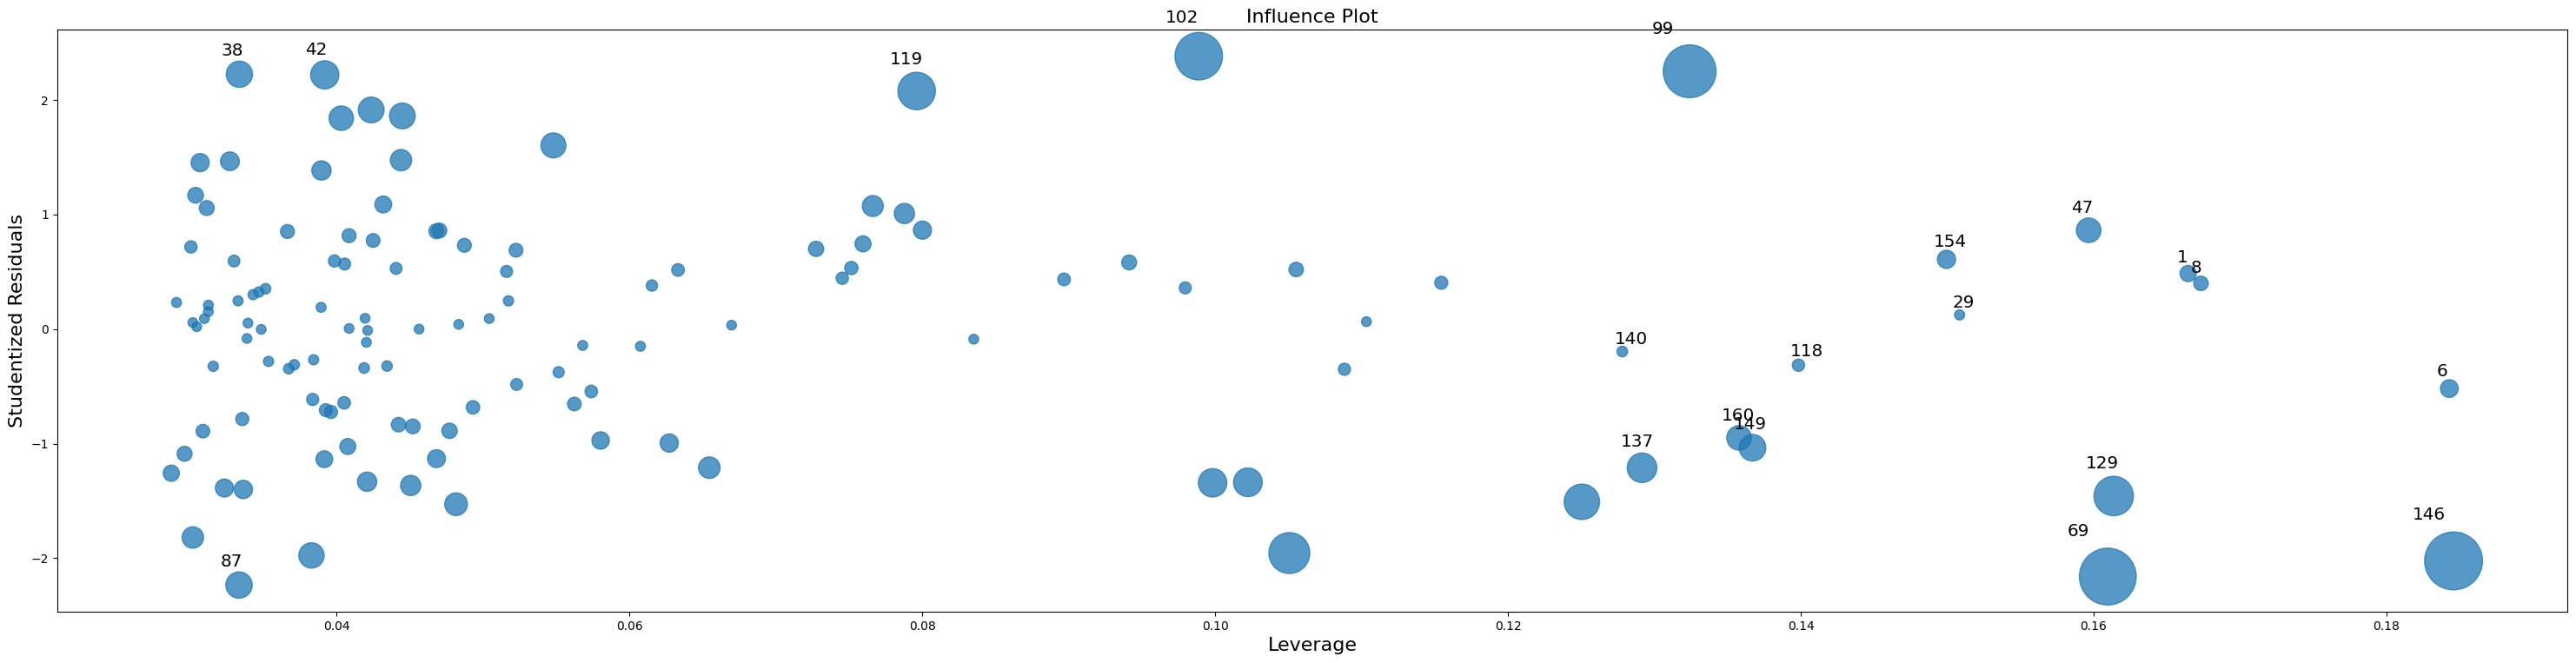

In [91]:
# Gráfico de alavancagem x resíduos padronizados e studentizados
fig = sm.graphics.influence_plot(modelo_OLS)
fig.set_size_inches(30, 8)
fig.tight_layout(pad=2.0)

- Gráficos de regressão: https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html

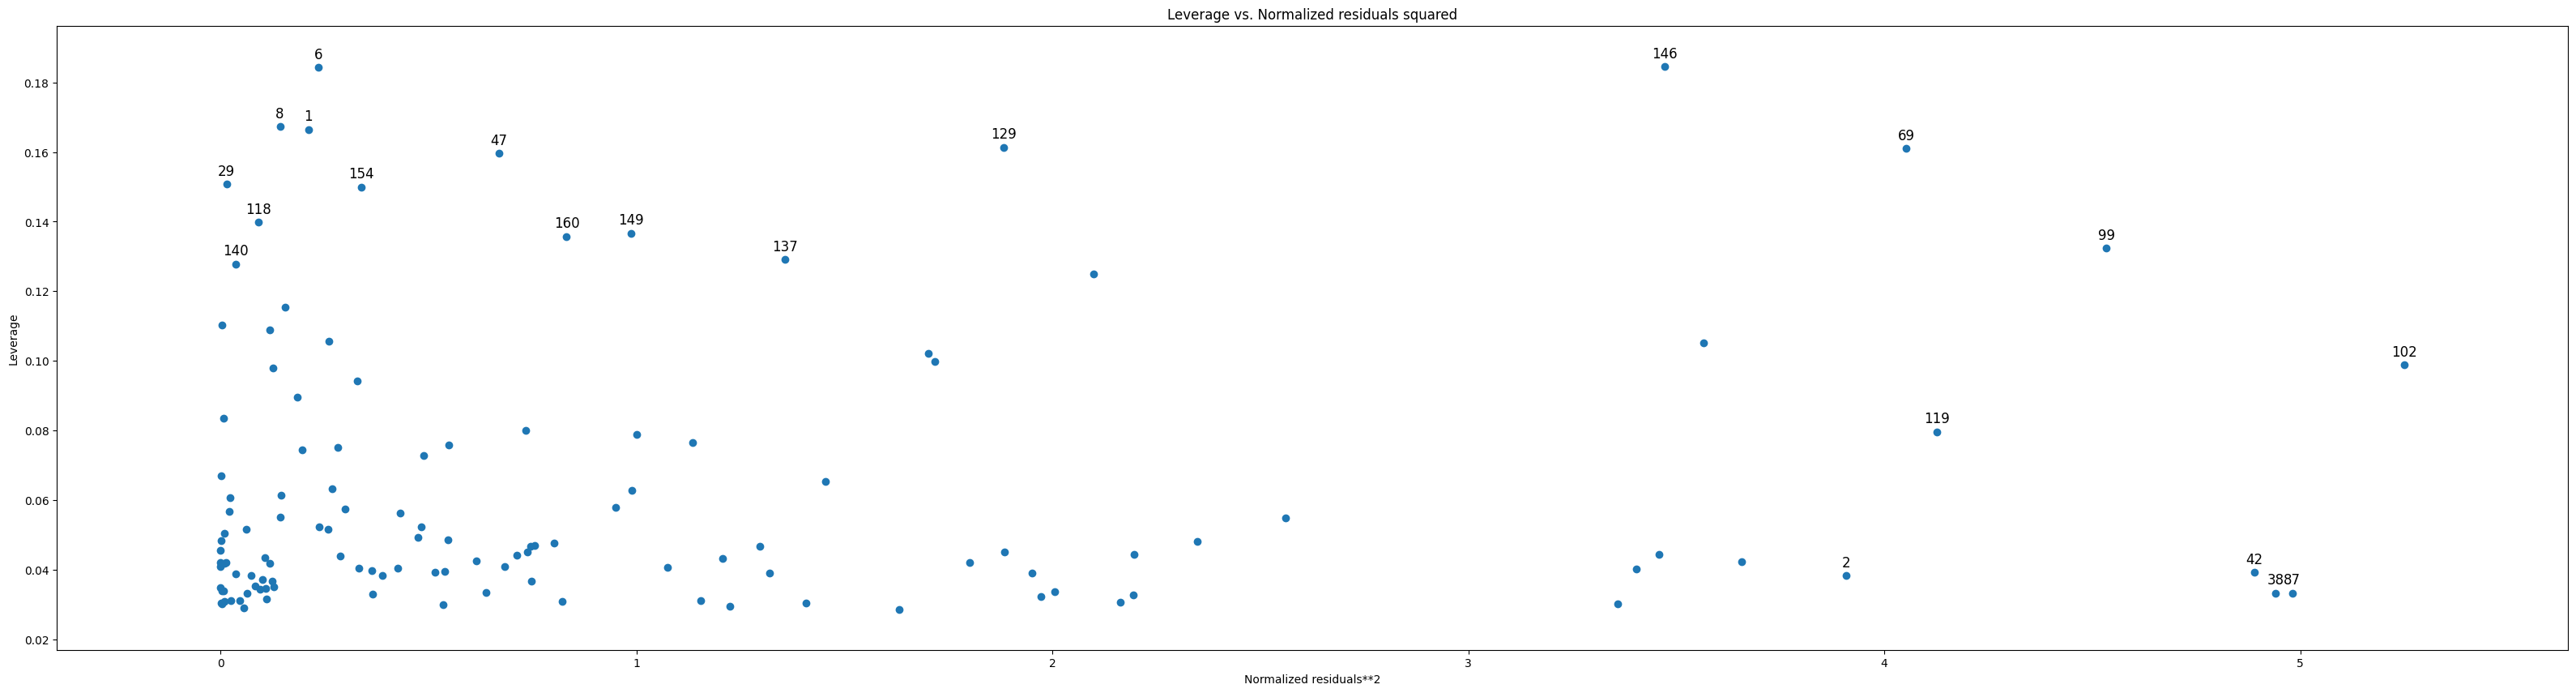

In [92]:
# Gráfico de alavancagem
fig, ax = plt.subplots(figsize=(40, 10))
fig = plot_leverage_resid2(modelo_OLS, ax=ax)

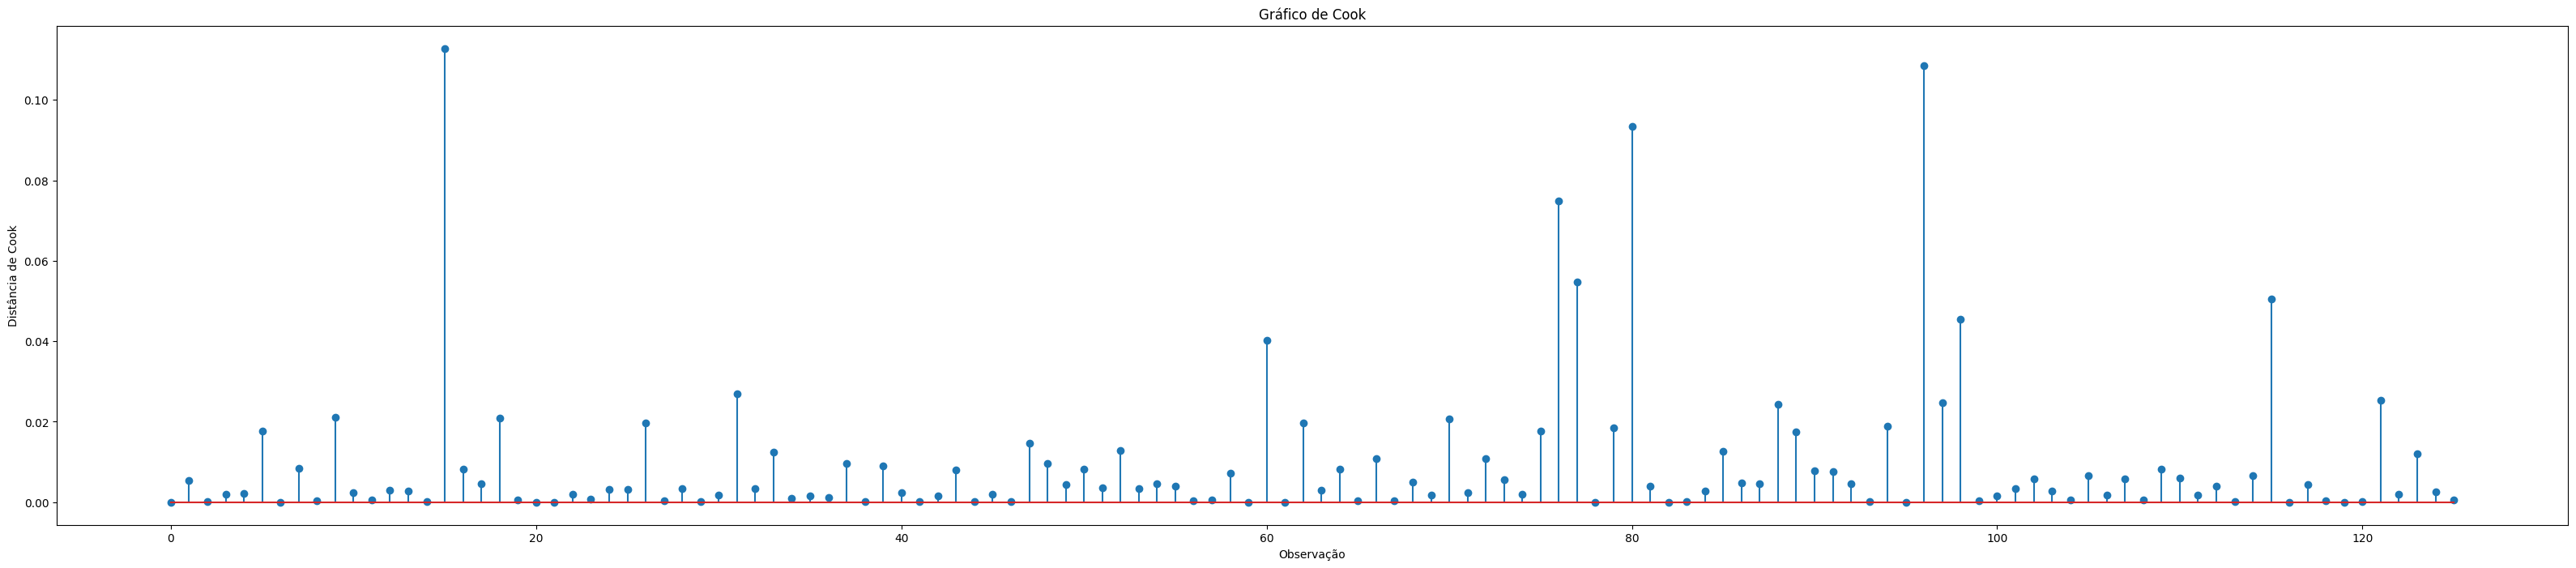

In [93]:
# Gráfico das distâncias de Cook
influence = modelo_OLS.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]
(c, _) = influence.cooks_distance

plt.figure(figsize=(40, 8))
plt.stem(c)
plt.xlabel('Observação')
plt.ylabel('Distância de Cook')
plt.title('Gráfico de Cook')
plt.show()

#### AVALIAÇÃO DE PREVISÃO

##### VISUALIZAÇÃO GRÁFICA DOS VALORES OBSERVADOS E DOS VALORES PREVISTOS - OS VALORES ESTÃO TRANSFORMADOS COM O LOGARITIMO NA BASE 10


- Gráficos de regressão: https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html

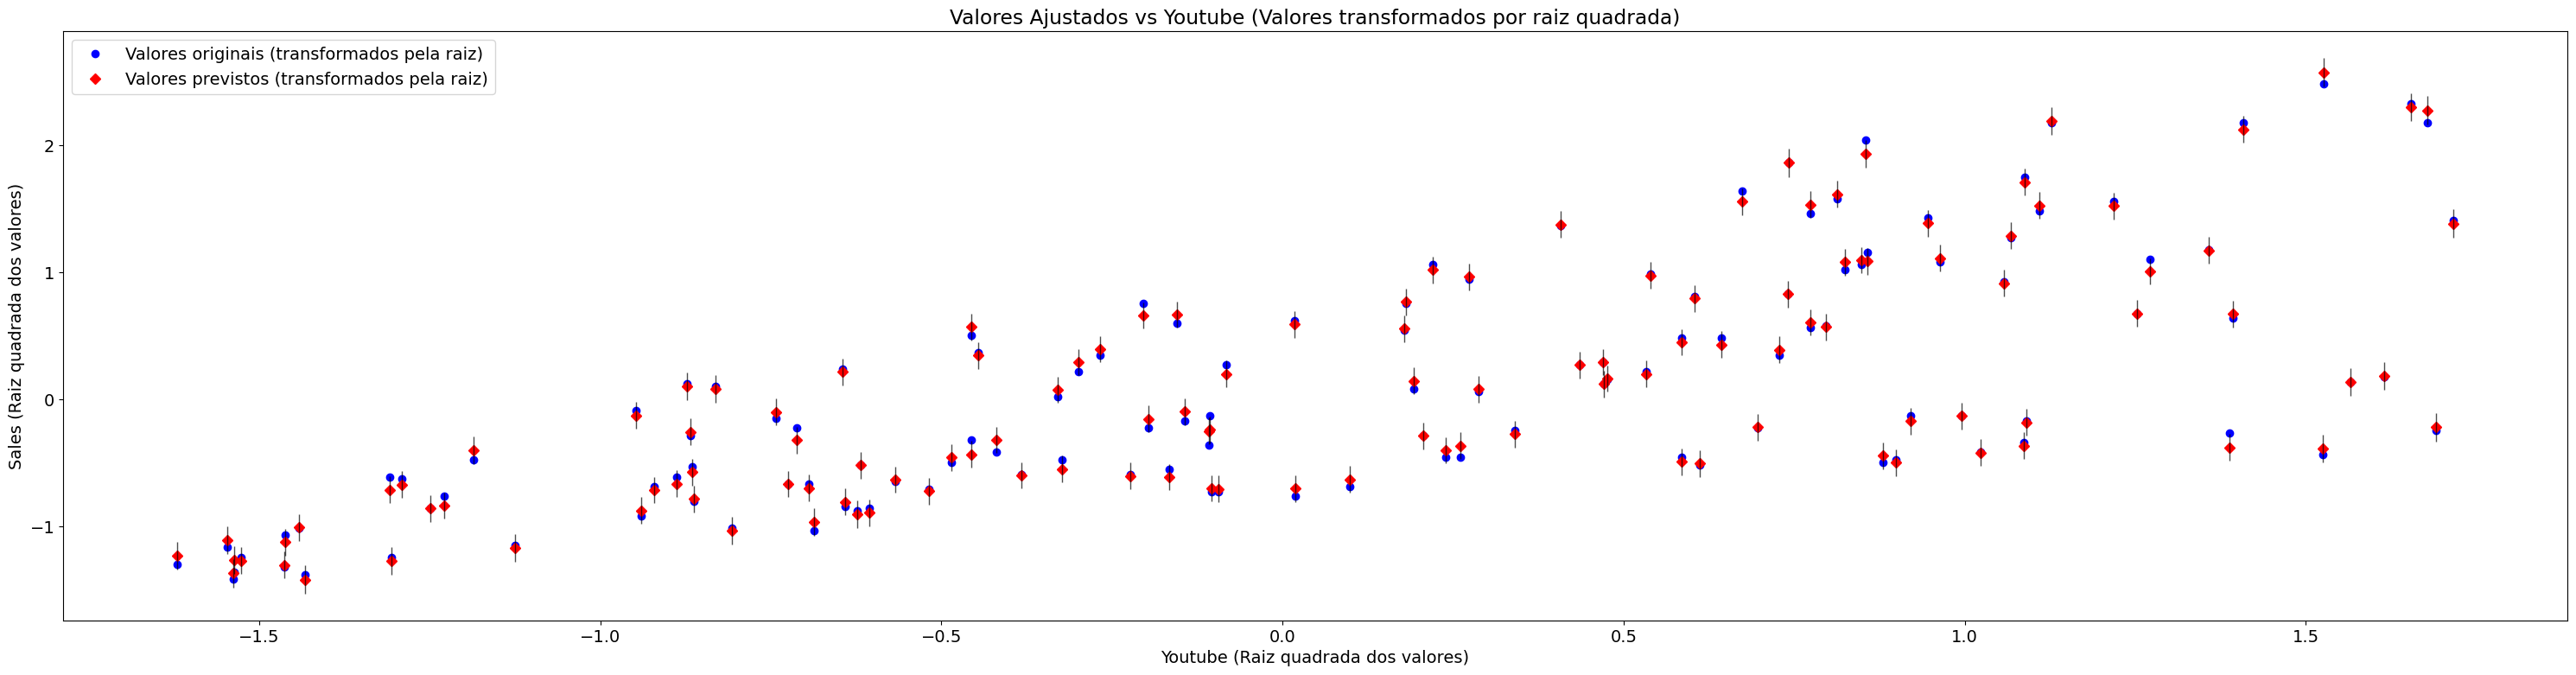

In [94]:
plt.rc("figure", figsize=(30, 8))
plt.rc("font", size=14)

fig = sm.graphics.plot_fit(modelo_OLS, 'youtube' )

plt.title("Valores Ajustados vs Youtube (Valores transformados por raiz quadrada)")
plt.xlabel("Youtube (Raiz quadrada dos valores)")
plt.ylabel("Sales (Raiz quadrada dos valores)")
plt.legend(["Valores originais (transformados pela raiz)", "Valores previstos (transformados pela raiz)"])
fig.tight_layout(pad=1.0)
plt.show()

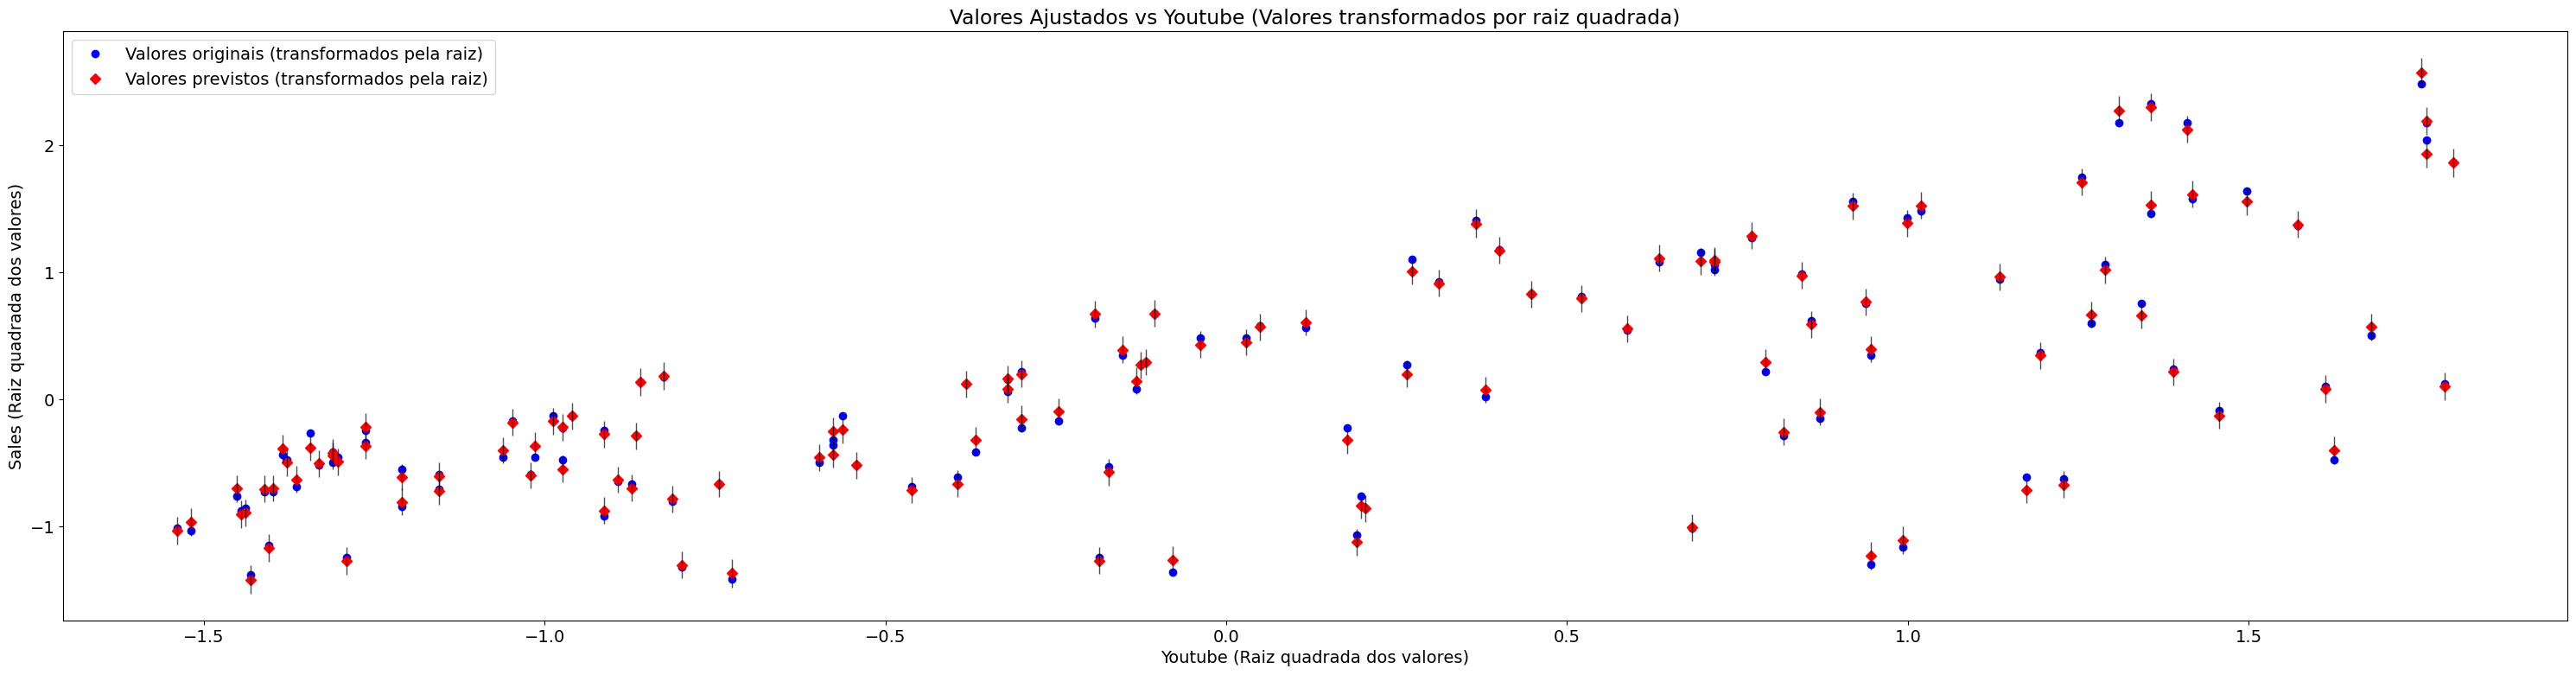

In [95]:
plt.rc("figure", figsize=(30, 8))
plt.rc("font", size=14)

fig = sm.graphics.plot_fit(modelo_OLS, 'facebook' )

plt.title("Valores Ajustados vs Youtube (Valores transformados por raiz quadrada)")
plt.xlabel("Youtube (Raiz quadrada dos valores)")
plt.ylabel("Sales (Raiz quadrada dos valores)")
plt.legend(["Valores originais (transformados pela raiz)", "Valores previstos (transformados pela raiz)"])
fig.tight_layout(pad=1.0)
plt.show()

##### BOXPLOT PARA COMPARAÇÃO

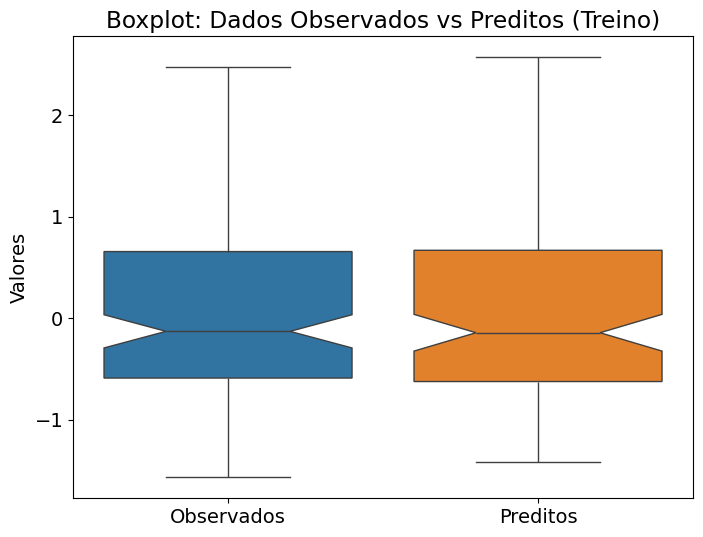

In [96]:
#Boxplot dos valores observados X valores preditos
comparacao_df = pd.DataFrame({'Observados': y_train, 'Preditos': y_train_pred})

# Gráfico de boxplot para comparação
plt.figure(figsize=(8, 6))
sns.boxplot(data=[comparacao_df['Observados'], comparacao_df['Preditos']], notch=True)
plt.xticks([0, 1], ['Observados', 'Preditos'])
plt.title('Boxplot: Dados Observados vs Preditos (Treino)')
plt.ylabel('Valores')
plt.show()


#### ANÁLISE DE INTERAÇÃO ENTRE AS VARIÁVEIS EXPLICATIVAS COM RIDGE

In [97]:
alphas = [0.01, 0.1, 1, 10, 100, 1000]

# RidgeCV faz a validação cruzada automaticamente e escolhe o melhor alpha
clf = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
clf.fit(X_train, y_train)


modelo_ridge = Ridge(alpha=clf.alpha_)  # Usar o melhor alpha encontrado
modelo_ridge.fit(X_train, y_train)

# Reverter coeficientes para a escala original
scaler_X = StandardScaler().fit(X)  # Escalonador para as variáveis independentes
scaler_Y = StandardScaler().fit(y.values.reshape(-1, 1))  # Escalonador para a variável dependente

# Obter os parâmetros do escalonamento
scale_X = scaler_X.scale_
mean_X = scaler_X.mean_
scale_Y = scaler_Y.scale_
mean_Y = scaler_Y.mean_

# Coeficientes ajustados no modelo escalonado
coef_scaled = modelo_ridge.coef_
intercept_scaled = modelo_ridge.intercept_


coef_interacao_original = coef_scaled[-1] * scaler_Y.scale_ / (scaler_X.scale_[0] * scaler_X.scale_[1])
print("Coeficiente de Interação na escala original:", coef_interacao_original)

Coeficiente de Interação na escala original: [0.23140475]


#### AVALIAÇÃO DE REGULARIZAÇÃO - TÉCNICA DE RIDGE

 “Quando a associação entre as variáveis independentes (preditoras) e a variável dependente (resposta) é linear, os modelos de regressão ajustados por mínimos quadrados ordinários (OLS) geram previsores não enviesados, mas podem apresentar alta variância nos coeficientes, a menos que o número de observações ( n ) seja substancialmente maior que o número de variáveis ( p ). Em situações em que  n  não é muito maior que  p , os modelos de regularização (como Ridge ou Lasso) podem ser utilizados para reduzir a variância das previsões, mantendo o viés relativamente inalterado.”

Singer, J. M., & Morettin, P. A. (2022). Estatística e Ciência de Dados. Página 404.

1 - Observações:
Modelo selecionado:
- O modelo que melhor se adequou ao problema e será utilizado para a avaliação dos resultados é descrito pela seguinte fórmula com regularização Ridge:
$
\min \Bigg[ \sum_{i=1}^n \left( y_i - \left( \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \beta_4 z_i + \beta_5 z_i^2 + \beta_6 z_i^3 + \beta_7 (x_i \cdot z_i) \right) \right)^2 + \lambda \sum_{j=1}^p \beta_j^2 \Bigg]
$
Onde:
- $ \lambda $  é o parâmetro de regularização que controla a penalização dos coeficientes.
- $ \ x_i $  representa a variável youtube.
- $ \ z_i $ representa a variável facebook.


2 - Robustez e generalização:

- Com a técnica de regularização Ridge aplicada ao modelo  $
\hat{y} = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 z + \beta_5 z^2 + \beta_6 z^3 + \beta_7 (x \cdot z) + \epsilon
$ ,  observou-se que o modelo se tornou mais robusto e com maior capacidade de generalização, reduzindo problemas de multicolinearidade e coeficientes instáveis.


3 - Impacto do parâmetro de regularização ($ \alpha $):

- Um valor de $\alpha$  muito alto resulta em subajuste, pois a penalização excessiva reduz drasticamente os coeficientes, simplificando demais o modelo.

- Um valor de $\alpha$  muito baixo pode levar a coeficientes instáveis, causando sobreajuste e dificultando a generalização para novos dados.

- O valor escolhido de $\alpha$ (por exemplo, 0.01) demonstrou equilibrar a complexidade do modelo com a estabilidade dos coeficientes, oferecendo um bom desempenho tanto no treinamento quanto na validação cruzada.


Singer, J. M., & Morettin, P. A. (2022).
Estatística e Ciência de Dados. São Paulo: Blucher.



- Técnica de regressão Ridge: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Ridge.html

In [98]:
# Divisão entre variáveis independentes e dependente
X = df[['facebook', 'facebook_quadratico', 'facebook_cubico',
        'youtube', 'youtube_quadratico', 'youtube_cubico',
        'facebook_youtube_interacao']]
y = df['sales']  # Variável dependente

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustando o modelo Ridge
modelo_ridge = Ridge(alpha=0.01)  # Alpha é o parâmetro de regularização
modelo_ridge.fit(X_train, y_train)

# Avaliação no conjunto de treino
y_train_pred = modelo_ridge.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Avaliação no conjunto de teste
y_test_pred = modelo_ridge.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

##### ANÁLISE DE NORMALIDADE DOS RESÍDUOS COM RIDGE

In [99]:
# Calcular os resíduos do modelo Ridge
residuos_ridge = y_train - modelo_ridge.predict(X_train)
# Teste de Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuos_ridge, 'norm', args=(residuos_ridge.mean(), residuos_ridge.std()))
nome_ks = ["Estatística do Teste de Kolmogorov-Smirnov", "p-valor"]
valores_ks = [stat_ks, p_value_ks]
# Teste de Shapiro-Wilk
stat_sw, p_value_sw = shapiro(residuos_ridge)
nome_sw = ["Estatística do Teste de Shapiro-Wilk", "p-valor"]
valores_sw = [stat_sw, p_value_sw]
# Resultados em DataFrame
resultados_ks_df = pd.DataFrame({"Medida": nome_ks, "Valor": valores_ks})
resultados_sw_df = pd.DataFrame({"Medida": nome_sw, "Valor": valores_sw})

print("Resultados do Teste de Kolmogorov-Smirnov:")
print(resultados_ks_df)
print("\nResultados do Teste de Shapiro-Wilk:")
print(resultados_sw_df)

# Interpretação dos testes
alpha = 0.05  # Nível de significância

Resultados do Teste de Kolmogorov-Smirnov:
                                       Medida     Valor
0  Estatística do Teste de Kolmogorov-Smirnov  0.050529
1                                     p-valor  0.888180

Resultados do Teste de Shapiro-Wilk:
                                 Medida     Valor
0  Estatística do Teste de Shapiro-Wilk  0.987407
1                               p-valor  0.300036


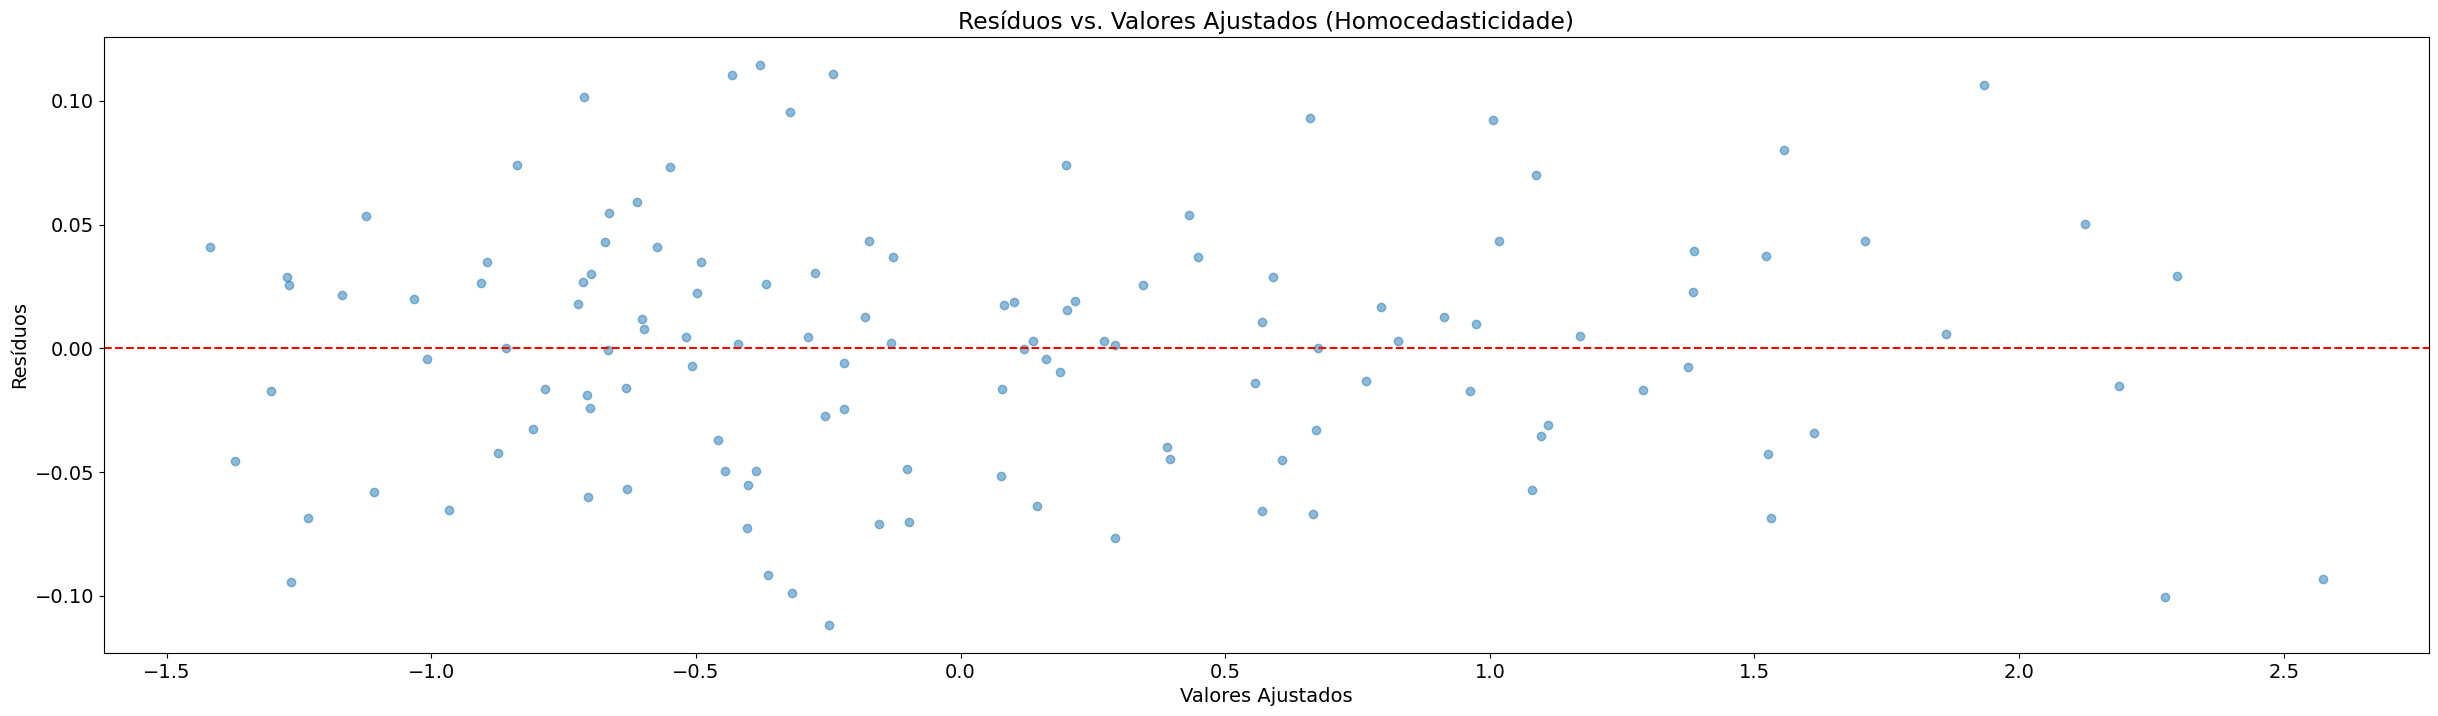

In [100]:
y_pred = modelo_ridge.predict(X_train)  # Ou X_test, dependendo do contexto
residuals = y_train - y_pred  # Use y_test se estiver avaliando o conjunto de teste

# Gráfico de resíduos vs. valores ajustados
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Resíduos vs. Valores Ajustados (Homocedasticidade)")
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos")
plt.show()

##### ANÁLISE DE HETEROCEDASTICIDADE - RIDGE

- Teste de Breusch-Pagan: https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html

- Teste de Goldfeld-Quandt: https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_goldfeldquandt.html#statsmodels.stats.diagnostic.het_goldfeldquandt

- Teste de White: https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_white.html#statsmodels.stats.diagnostic.het_white


In [101]:
# Teste de heterocedasticidade
# Resíduos do conjunto de treino
residuals_train = y_train - y_train_pred

# Adicionando uma constante ao conjunto de treino para os testes
X_train_const = sm.add_constant(X_train)

# Teste de Breusch-Pagan 
nome_bp = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
bp_test = het_breuschpagan(residuals_train, X_train_const)
resultados_bp = pd.DataFrame({"Estatística": nome_bp, "Valor": bp_test})
print("Teste de Breusch-Pagan (Treino):")
print(resultados_bp)

# Teste de Goldfeld-Quandt 
nome_gq = ["GQ Statistic", "p-value"]
gq_test = het_goldfeldquandt(residuals_train, X_train_const)
resultados_gq = pd.DataFrame({"Estatística": nome_gq, "Valor": gq_test[:2]})
print("\nTeste de Goldfeld-Quandt (Treino):")
print(resultados_gq)

# Teste de White 
nome_white = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
white_test = het_white(residuals_train, X_train_const)
resultados_white = pd.DataFrame({"Estatística": nome_white, "Valor": white_test})
print("\nTeste de White (Treino):")
print(resultados_white)

Teste de Breusch-Pagan (Treino):
                     Estatística     Valor
0  Lagrange multiplier statistic  4.969738
1                        p-value  0.663656
2                        f-value  0.692187
3                      f p-value  0.678493

Teste de Goldfeld-Quandt (Treino):
    Estatística     Valor
0  GQ Statistic  1.465218
1       p-value  0.079884

Teste de White (Treino):
                     Estatística      Valor
0  Lagrange multiplier statistic  32.243807
1                        p-value   0.095178
2                        f-value   1.525172
3                      f p-value   0.079011


##### VALIDAÇÃO CRUZADA

In [102]:
# Configuração do K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Modelo Ridge com o melhor alpha encontrado (exemplo: alpha = 0.01)
modelo_ridge_Kfold = Ridge(alpha=0.01)

# Avaliação do modelo usando K-Fold
scores_mse = cross_val_score(modelo_ridge_Kfold, X, y, cv=kf, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(modelo_ridge_Kfold, X, y, cv=kf, scoring='r2')

# Resultados
print(f"MSE médio (K-Fold): {-scores_mse.mean():.4f}")
print(f"Desvio Padrão do MSE: {scores_mse.std():.4f}")
print(f"R² médio (K-Fold): {scores_r2.mean():.4f}")
print(f"Desvio Padrão do R²: {scores_r2.std():.4f}")

MSE médio (K-Fold): 0.0033
Desvio Padrão do MSE: 0.0011
R² médio (K-Fold): 0.9960
Desvio Padrão do R²: 0.0014


In [103]:
# Resultados
print("Desempenho do modelo Ridge:")
print(f"R² (Treino): {r2_train:.4f}")
print(f"R² (Teste): {r2_test:.4f}")
print(f"MSE (Treino): {mse_train:.4f}")
print(f"MSE (Teste): {mse_test:.4f}")

# Comparação entre treino e teste
print("\nDiferença entre os conjuntos de treino e teste:")
print(f"R² Treino - Teste: {r2_train - r2_test:.4f}")
print(f"MSE Treino - Teste: {mse_train - mse_test:.4f}")

Desempenho do modelo Ridge:
R² (Treino): 0.9971
R² (Teste): 0.9954
MSE (Treino): 0.0025
MSE (Teste): 0.0047

Diferença entre os conjuntos de treino e teste:
R² Treino - Teste: 0.0017
MSE Treino - Teste: -0.0022


In [104]:
# Ajuste do modelo Ridge:

#Cálculos para resultado de teste:
y_pred_train = modelo_ridge.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)

# Cálculo do Log-Likelihood aproximado - Log-Likelihood = ln(L(theta| dados))
n = len(y_train)  # número de observações
sse = np.sum((y_train - y_pred_train) ** 2)  # Soma dos quadrados dos resíduos
log_likelihood_train = -n / 2 * np.log(2 * np.pi * mse_train) - sse / (2 * mse_train)

# Cálculo do AIC (critério de Akaike) - AIC = 2k - 2 * log-likelihood
k = X_test.shape[1] + 1  # número de parâmetros (coeficientes + intercepto)
aic_train = 2 * k - 2 * log_likelihood_train
# Cálculo do BIC (critério bayesiano de informação) - BIC = k * ln(n) - 2 * log-likelihood
bic_train = k * np.log(n) - 2 * log_likelihood_train

# Cáculos para resultatos de teste:
y_pred_test = modelo_ridge.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

# Cálculo do Log-Likelihood aproximado - Log-Likelihood = ln(L(theta| dados))
n = len(y_test)  # número de observações
sse = np.sum((y_test - y_pred_test) ** 2)  # Soma dos quadrados dos resíduos
log_likelihood_test = -n / 2 * np.log(2 * np.pi * mse_test) - sse / (2 * mse_test)

# Cálculo do AIC (critério de Akaike) - AIC = 2k - 2 * log-likelihood
k = X_test.shape[1] + 1  # número de parâmetros (coeficientes + intercepto)
aic_test = 2 * k - 2 * log_likelihood_test
# Cálculo do BIC (critério bayesiano de informação) - BIC = k * ln(n) - 2 * log-likelihood
bic_test = k * np.log(n) - 2 * log_likelihood_test

“A regressão Ridge, introduzida por Hoerl e Kennard (1970), foi inicialmente desenvolvida para solucionar o problema da multicolinearidade, que prejudica a estabilidade e a interpretação dos coeficientes estimados nos modelos de regressão. Além disso, a técnica tem ampla aplicação para lidar com o sobreajuste, que ocorre em cenários onde o modelo ajusta-se excessivamente aos dados de treinamento, resultando em baixa capacidade de generalização para novos dados. Ao penalizar os coeficientes maiores, a técnica proporciona um equilíbrio entre viés e variância, favorecendo a construção de modelos mais robustos.”

Singer, J. M., & Morettin, P. A. (2022). Estatística e Ciência de Dados. Página 408.

Observações:

- Os valores inicialmente elevados e negativos de AIC (Critério de Akaike) e BIC (Critério Bayesiano de Informação), que indicavam a possibilidade de sobreajuste no modelo, foram reduzidos de forma significativa com o uso da regularização Ridge.
- Isso sugere que a técnica está adequando os coeficientes, minimizando flutuações excessivas e promovendo um modelo mais parcimonioso e com melhor capacidade de generalização.

In [105]:
print("Métricas de Desempenho do Modelo Ridge:")
print(f"\nLog-Likelihood Treino: {log_likelihood_train:.2f}")
print(f"Log-Likelihood Teste: {log_likelihood_test:.2f}")
print(f"\nAIC Treino: {aic_train:.2f}")
print(f"AIC Teste: {aic_test:.4f}")
print(f"\nBIC Treino: {bic_train:.2f}")
print(f"BIC Teste: {bic_test:.4f}")

Métricas de Desempenho do Modelo Ridge:

Log-Likelihood Treino: 198.63
Log-Likelihood Teste: 40.30

AIC Treino: -381.27
AIC Teste: -64.5964

BIC Treino: -358.58
BIC Teste: -52.8705


##### AJUSTE DE HIPERPARÂMENTRO - ALPHA $\alpha$

Validação cruzada e ajuste de hiperparâmetro de Ridge_fb - alpha $\alpha$:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

In [106]:
# Defina a lista de valores de alpha que deseja testar
alphas = [0.01, 0.1, 1, 10, 100, 1000]

# RidgeCV faz a validação cruzada automaticamente e escolhe o melhor alpha
clf = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
clf.fit(X_train, y_train)

# Reverter os coeficientes para a escala original
coef_original = coef_scaled * scale_Y / scale_X
intercept_original = intercept_scaled * scale_Y + mean_Y - np.sum((coef_scaled * mean_X * scale_Y) / scale_X)

print("Coeficientes na escala original:", coef_original)
print("Intercepto na escala original:", intercept_original)
print("Melhor valor de alpha:", clf.alpha_)

Coeficientes na escala original: [ 0.          0.517357    0.00735654  0.00264525  0.58004545 -0.1334248
  0.02550139  0.24274348]
Intercepto na escala original: [0.22355849]
Melhor valor de alpha: 0.01


##### CURVA DE APRENDIZADO DO MODELO - RIGDE

Observações:
1.	Erro de treinamento:

- A curva de aprendizado demonstra que o erro de treinamento diminui progressivamente conforme mais dados são usados.

- Isso indica que o modelo está aprendendo bem a relação entre as variáveis independentes e a variável dependente, e não apresenta dificuldades para ajustar os dados.

2.	Erro de teste:

- O erro de teste se estabiliza, o que sugere que o modelo está conseguindo generalizar adequadamente para novos dados.

- Não há evidências de sobreajuste (overfitting), já que o erro de teste não aumenta conforme mais dados de treinamento são adicionados.

- Não há sinais de subajuste (underfitting), pois o erro de teste é consistente e estável.

- Curva de aprendizado do modelo:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

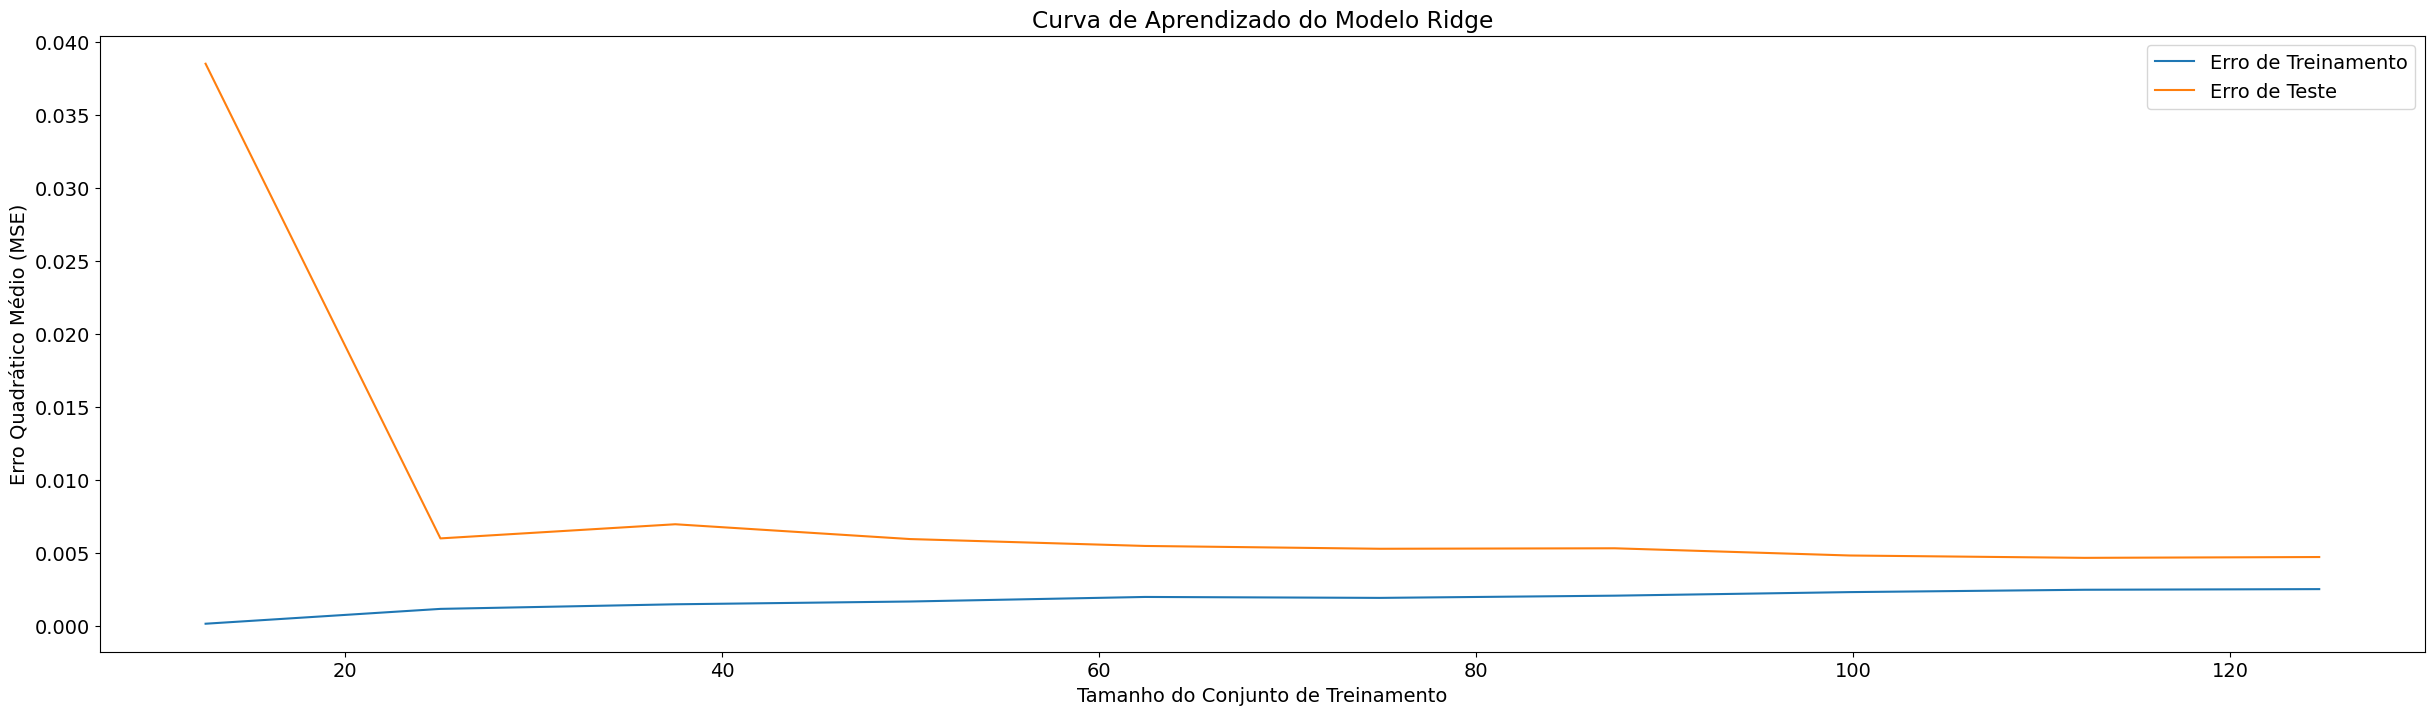

In [107]:
# Curva de aprendizado do modelo Ridge
train_errors, test_errors = [], []
train_sizes = np.linspace(0.1, 0.99, 10)  # Vai até 0.99 para evitar o erro de 1.0

# Loop para treinar o modelo com diferentes tamanhos de conjunto de treinamento
for train_size in train_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
    modelo = Ridge(alpha=0.01)  # Ajuste do modeloo Ridge com alpha fixo
    modelo.fit(X_train_subset, y_train_subset)

    # Calcular o erro no conjunto de treinamento e de teste
    train_errors.append(mean_squared_error(y_train_subset, modelo.predict(X_train_subset)))
    test_errors.append(mean_squared_error(y_test, modelo.predict(X_test)))

# Plotando a Curva de Aprendizado
plt.plot(train_sizes * len(X_train), train_errors, label="Erro de Treinamento")
plt.plot(train_sizes * len(X_train), test_errors, label="Erro de Teste")
plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.title("Curva de Aprendizado do Modelo Ridge")
plt.legend()
plt.show()

### Conclusão

1. Relação entre as variáveis

- Correlação Inicial: As análises exploratórias mostraram que há correlações significativas entre as variáveis youtube, facebook, e sales. A variável newspaper, por outro lado, apresentou menor correlação com sales, indicando menor influência direta.

Impacto não-linear e interação:

- A relação entre youtube e sales, bem como entre facebook e sales, é também não-linear, conforme identificado pela inclusão de termos polinomiais de grau 2 e 3. Isso evidencia que o impacto do investimento nessas mídias varia dependendo do nível de investimento.

Interação: 

- O termo de interação entre youtube e facebook foi significativo (p < 0.05), indicando que o impacto de um depende do nível de investimento no outro. Isso significa que campanhas conjuntas em ambas as plataformas têm um efeito combinado mais forte sobre as vendas.

2. Fatores que mais impactam na geração de Leads

Modelo OLS:

- No modelo inicial de regressão linear (OLS), os coeficientes mostraram forte influência de youtube e facebook em sales, mas a presença de multicolinearidade tornou os coeficientes instáveis.

Modelo Ridge:

O modelo Ridge foi usado para corrigir multicolinearidade e estabilizar os coeficientes. Os resultados indicaram que:

- Youtube tem o maior impacto sobre sales, especialmente em níveis moderados a altos de investimento.

- Facebook também influencia significativamente as vendas, mas seu impacto é relativamente menor que o de youtube.

- Interação (youtube x facebook): Embora não tenha sido o fator predominante, a interação entre as variáveis mostrou-se estatisticamente significativa, reforçando a importância de uma estratégia integrada entre as plataformas.

3. Modelo de predição de valores

Desempenho do modelo Ridge:

 - O modelo de regressão Ridge apresentou:

- Alto $ R^2 $  no conjunto de teste, indicando que o modelo explica bem a variabilidade nos dados.

- Redução do overfitting em comparação ao modelo OLS, devido à penalização aplicada aos coeficientes.

Capacidade de predição:

- O modelo permite prever valores de sales com boa precisão para diferentes níveis de investimento em youtube e facebook.

- Um exemplo prático seria estimar o retorno de vendas esperado ao aumentar o investimento em youtube e facebook conjuntamente, ou otimizar a distribuição de orçamento entre as duas plataformas.

Implicações práticas

Investimento otimizado:

- Focar em investimentos moderados a altos em youtube traz o maior impacto nas vendas.

- Combinar investimentos em facebook com youtube pode amplificar o retorno devido à interação significativa entre as plataformas.

 Modelo como ferramenta de planejamento:
 
- O modelo gerado serve como uma ferramenta robusta para prever retornos futuros de vendas com base em investimentos em publicidade.

- Permite simulações de cenários para ajudar no planejamento estratégico de campanhas publicitárias.

Conclusão geral

A análise atingiu os três objetivos propostos:

1.	Entendimento da relação entre as variáveis: Identificamos correlações significativas, padrões não-lineares e interação entre youtube e facebook.

2.	Fatores mais impactantes: youtube foi o fator com maior influência, seguido por facebook e sua interação com youtube.

3.	Modelo de predição: O modelo Ridge mostrou-se adequado para prever sales com alta precisão, proporcionando insights valiosos para otimização de investimentos.

Referências

CAMPOS, D. P.; RÊGO, C. A.; MENDONÇA, S. A. Tópicos em Probabilidade e Estatística: Aplicações com Distribuições Contínuas. São Paulo: Atlas, 2012.

SINGER, J. M.; MORETTIN, P. A. Estatística e Ciência de Dados. São Paulo: Blucher, 2022.

SINGER, J. M.; NOBRE, J. S.; ROCHA, F. M. Análise de Dados Longitudinais. São Paulo: Blucher, 2018.